In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn

import matplotlib.pyplot as plt

from utils.data.datasets import ModelParamsDataset
from utils.model.models import MLP
import utils.model.train as trainer
from utils.config import config as cfg

from tqdm.notebook import tqdm

from dotenv import dotenv_values
from pathlib import Path
import wandb
import random
import string

..\data\eight_angles.csv


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Train sample: 56000
Validation sample: 16000
Test sample: 8000


wandb: Currently logged in as: idavron (idavron-team). Use `wandb login --relogin` to force relogin


  0%|          | 0/300 [00:00<?, ?it/s]

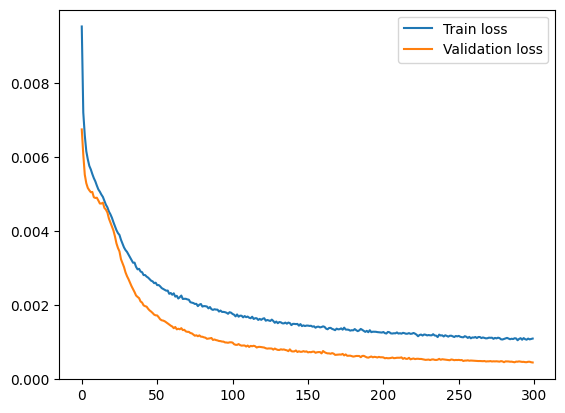

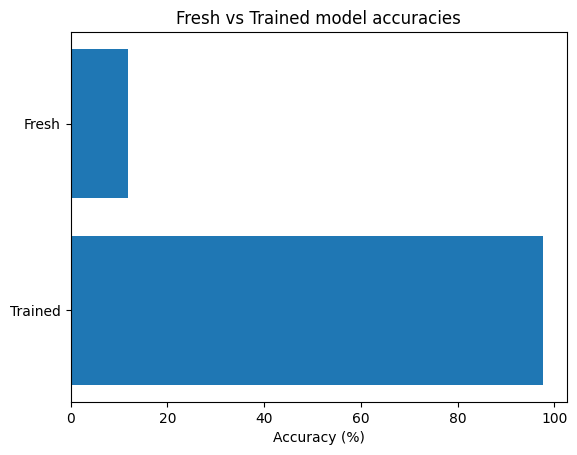

In [ ]:
config_name = "classifier_1.yaml"
config = cfg.load_config(config_name, True)
default_dirs = cfg.get_default_dirs()
models_dir = default_dirs["models_dir"]
datasets_dir = default_dirs["datasets_dir"]


name = config["name"]
# Hyperparameters
hyperparameters = config["hyperparameters"]
epochs = hyperparameters["epochs"]
learning_rate = hyperparameters["learning_rate"]
seed = hyperparameters["seed"]

# Model config
model_config = config["model"]
input_dim = model_config["input_dim"]
hidden_dims = model_config["hidden_dims"]
output_dim = model_config["output_dim"]
dropout = model_config.get("dropout", 0.0)
use_batch_norm = model_config.get("use_batch_norm", False)
output_activation = model_config.get("output_activation", "softmax")


# Load dataset
dataset_config = config["dataset"]
dataset_name = dataset_config["name"]
dataset_splits = dataset_config["splits"]
dataset_seed = dataset_config["seed"]

dataset_path = datasets_dir / dataset_name
print(dataset_path)
# Create a dataset
dataset = ModelParamsDataset(dataset_path, 45)

torch.manual_seed(dataset_seed)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Split into train, validation and test sets
dataset_train, dataset_valid, dataset_test = torch.utils.data.random_split(dataset, dataset_splits)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=32, shuffle=True)
dataloader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=32, shuffle=True)
dataloader_test = torch.utils.data.DataLoader(dataset_test)

print("Train sample:", len(dataset_train))
print("Validation sample:", len(dataset_valid))
print("Test sample:", len(dataset_test))


torch.manual_seed(seed)
wandb_config = dotenv_values("../.env")
wandb.init(project=wandb_config["WANDB_PROJECT"], entity=wandb_config["WANDB_ENTITY"], config=config, group="weight_classifier")

# Init
model = MLP(input_dim, hidden_dims, output_dim, dropout, use_batch_norm, output_activation)
model.to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_losses = []
valid_losses = []

# Training
for epoch in tqdm(range(epochs)):
    total_loss = 0
    model.train()
    for X, y in dataloader_train:
        X = X.to(device)
        y = y.to(device)
        y_pred = model(X)
        y = torch.nn.functional.one_hot(y, output_dim).float()
        loss = criterion(y_pred, y)
        total_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    total_loss /= len(dataloader_train.dataset)
    train_losses.append(total_loss)
    wandb.log({"train_loss": total_loss})

    total_loss = 0
    model.eval()
    for X, y in dataloader_valid:
        X = X.to(device)
        y = y.to(device)
        y_pred = model(X.float())
        y = torch.nn.functional.one_hot(y, num_classes=output_dim).float()
        loss = criterion(y_pred, y)
        total_loss += loss.item()
    
    total_loss /= len(dataloader_valid.dataset)
    valid_losses.append(total_loss)
    wandb.log({"valid_loss": total_loss})


plt.plot(train_losses, label="Train loss")
plt.plot(valid_losses, label="Validation loss")
plt.legend()
plt.show()

# Check improvement compared to a fresh model
model_fresh = MLP(input_dim, hidden_dims, output_dim, dropout, use_batch_norm, output_activation)
model_fresh.to(device)
model_fresh.eval()
total_correct = 0
for X, y in dataloader_test:
    X = X.to(device)
    y = y.to(device)
    y_pred = model_fresh(X.float())
    # Accuracy
    y_pred = torch.argmax(y_pred, dim=1)
    correct = (y_pred == y).sum()
    total_correct += correct
accuracy_fresh = total_correct / len(dataloader_test.dataset) * 100

total_correct = 0
model.eval()
for X, y in dataloader_test:
    X = X.to(device)
    y = y.to(device)
    y_pred = model(X.float())
    # Accuracy
    y_pred = torch.argmax(y_pred, dim=1)
    correct = (y_pred == y).sum()
    total_correct += correct

accuracy_trained = total_correct / len(dataloader_test.dataset) * 100

wandb.log({"accuracy_trained": accuracy_trained})

plt.title("Fresh vs Trained model accuracies")
plt.barh(["Trained", "Fresh"], [accuracy_trained.cpu().detach().numpy(), accuracy_fresh.cpu().detach().numpy()])
plt.xlabel("Accuracy (%)")
plt.show()

torch.save(model.state_dict(), models_dir / f"{name}.pth")


C:\Projects\Python\master-thesis\data\eight_angles.csv
Train sample: 56000
Validation sample: 16000
Test sample: 8000


100%|██████████| 75/75 [14:48<00:00, 11.84s/it]


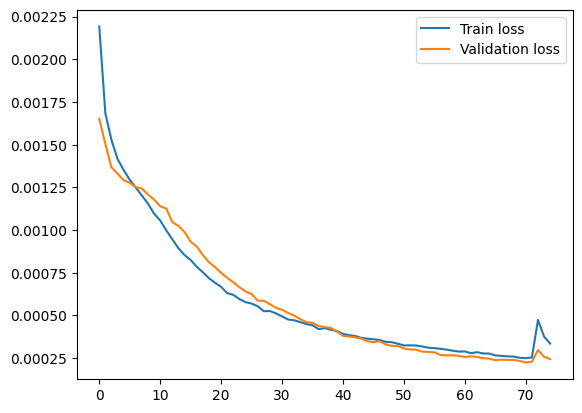

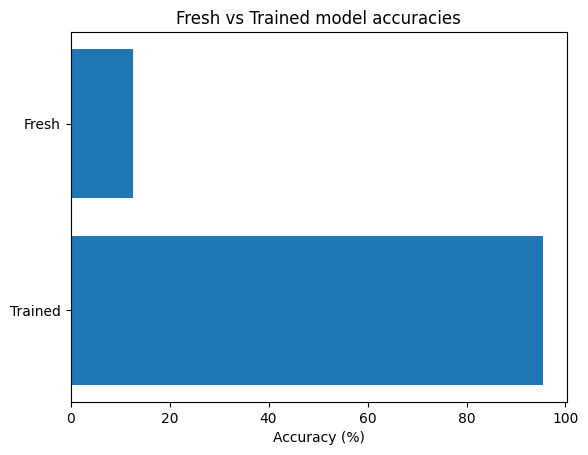

accuracy_trained,▁
train_loss,█▆▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁
valid_loss,█▇▆▆▆▆▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy_trained,95.45
train_loss,0.00033
valid_loss,0.00024


In [19]:
config_name = "classifier_7.yaml"
config = cfg.load_config(config_name)
default_dirs = cfg.get_default_dirs()
models_dir = Path(default_dirs["models_dir"])
datasets_dir = Path(default_dirs["datasets_dir"])


name = ''.join(random.choices(string.ascii_lowercase, k=7))
# Hyperparameters
hyperparameters = config["hyperparameters"]
epochs = hyperparameters["epochs"]
learning_rate = hyperparameters["learning_rate"]
seed = hyperparameters["seed"]

# Model config
model_config = config["model"]
input_dim = model_config["input_dim"]
hidden_dims = model_config["hidden_dims"]
output_dim = model_config["output_dim"]
dropout = model_config.get("dropout", 0.0)
use_batch_norm = model_config.get("use_batch_norm", False)
output_activation = model_config.get("output_activation", "softmax")


# Load dataset
dataset_config = config["dataset"]
dataset_name = dataset_config["name"]
dataset_splits = dataset_config["splits"]
batch_size = dataset_config["batch_size"]
dataset_seed = dataset_config["seed"]

dataset_path = datasets_dir / dataset_name
print(dataset_path)
# Create a dataset
dataset = ModelParamsDataset(dataset_path, 45)

torch.manual_seed(dataset_seed)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Split into train, validation and test sets
dataset_train, dataset_valid, dataset_test = torch.utils.data.random_split(dataset, dataset_splits)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataloader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=True)
dataloader_test = torch.utils.data.DataLoader(dataset_test)

print("Train sample:", len(dataset_train))
print("Validation sample:", len(dataset_valid))
print("Test sample:", len(dataset_test))


torch.manual_seed(seed)
wandb_config = dotenv_values("../.env")
wandb.init(project=wandb_config["WANDB_PROJECT"], entity=wandb_config["WANDB_ENTITY"], config=config, group="weight_classifier")

# Init
model = MLP(input_dim, hidden_dims, output_dim, dropout, use_batch_norm, output_activation)
model.to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_losses, valid_losses = trainer.train_mlp(model, epochs, learning_rate, criterion, optimizer, dataloader_train, dataloader_valid)

plt.plot(train_losses, label="Train loss")
plt.plot(valid_losses, label="Validation loss")
plt.legend()
plt.show()

# Check improvement compared to a fresh model
model_fresh = MLP(input_dim, hidden_dims, output_dim, dropout, use_batch_norm, output_activation)
accuracy_fresh = trainer.get_accuracy(model_fresh, dataloader_test)
accuracy_trained = trainer.get_accuracy(model, dataloader_test)

wandb.log({"accuracy_trained": accuracy_trained})

plt.title("Fresh vs Trained model accuracies")
plt.barh(["Trained", "Fresh"], [accuracy_trained, accuracy_fresh])
plt.xlabel("Accuracy (%)")
plt.show()

torch.save(model.state_dict(), models_dir / f"{name}.pth")
wandb.finish()

C:\Projects\Python\master-thesis\data\eight_angles.csv


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Train sample: 56000
Validation sample: 16000
Test sample: 8000


wandb: Currently logged in as: idavron (idavron-team). Use `wandb login --relogin` to force relogin


100%|██████████| 50/50 [13:04<00:00, 15.68s/it]


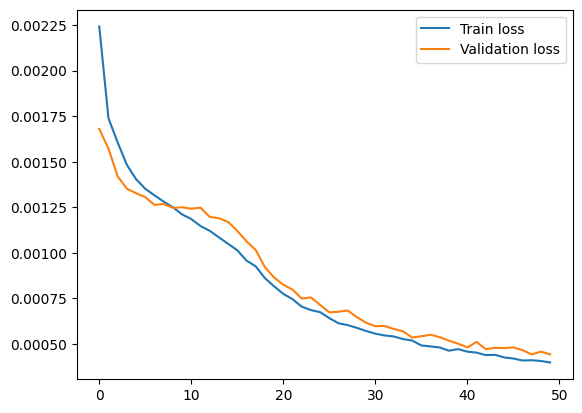

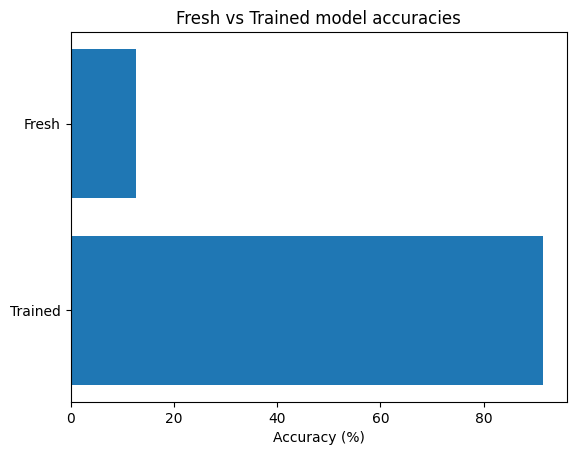

accuracy_trained,▁
train_loss,█▆▆▅▅▄▄▄▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▇▇▆▆▆▆▆▆▆▅▅▅▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
accuracy_trained,91.47501
train_loss,0.0004
valid_loss,0.00044


In [3]:
config_name = "classifier_9.yaml"
config = cfg.load_config(config_name)
default_dirs = cfg.get_default_dirs()
models_dir = Path(default_dirs["models_dir"])
datasets_dir = Path(default_dirs["datasets_dir"])


name = ''.join(random.choices(string.ascii_lowercase, k=7))
# Hyperparameters
hyperparameters = config["hyperparameters"]
epochs = hyperparameters["epochs"]
learning_rate = hyperparameters["learning_rate"]
seed = hyperparameters["seed"]

# Model config
model_config = config["model"]
input_dim = model_config["input_dim"]
hidden_dims = model_config["hidden_dims"]
output_dim = model_config["output_dim"]
dropout = model_config.get("dropout", 0.0)
use_batch_norm = model_config.get("use_batch_norm", False)
output_activation = model_config.get("output_activation", "softmax")


# Load dataset
dataset_config = config["dataset"]
dataset_name = dataset_config["name"]
dataset_splits = dataset_config["splits"]
batch_size = dataset_config["batch_size"]
dataset_seed = dataset_config["seed"]

dataset_path = datasets_dir / dataset_name
print(dataset_path)
# Create a dataset
dataset = ModelParamsDataset(dataset_path, 45)

torch.manual_seed(dataset_seed)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Split into train, validation and test sets
dataset_train, dataset_valid, dataset_test = torch.utils.data.random_split(dataset, dataset_splits)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataloader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=True)
dataloader_test = torch.utils.data.DataLoader(dataset_test)

print("Train sample:", len(dataset_train))
print("Validation sample:", len(dataset_valid))
print("Test sample:", len(dataset_test))


torch.manual_seed(seed)
wandb_config = dotenv_values("../.env")
wandb.init(project=wandb_config["WANDB_PROJECT"], entity=wandb_config["WANDB_ENTITY"], config=config, group="weight_classifier")

# Init
model = MLP(input_dim, hidden_dims, output_dim, dropout, use_batch_norm, output_activation)
model.to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_losses, valid_losses = trainer.train_mlp(model, epochs, learning_rate, criterion, optimizer, dataloader_train, dataloader_valid)

plt.plot(train_losses, label="Train loss")
plt.plot(valid_losses, label="Validation loss")
plt.legend()
plt.show()

# Check improvement compared to a fresh model
model_fresh = MLP(input_dim, hidden_dims, output_dim, dropout, use_batch_norm, output_activation)
accuracy_fresh = trainer.get_accuracy(model_fresh, dataloader_test)
accuracy_trained = trainer.get_accuracy(model, dataloader_test)

wandb.log({"accuracy_trained": accuracy_trained})

plt.title("Fresh vs Trained model accuracies")
plt.barh(["Trained", "Fresh"], [accuracy_trained, accuracy_fresh])
plt.xlabel("Accuracy (%)")
plt.show()

torch.save(model.state_dict(), models_dir / f"{name}.pth")
wandb.alert(title="Model training finished", text=f"Model [{config_name}] training finished successfully.")
wandb.finish()

C:\Projects\Python\master-thesis\data\eight_angles.csv
Train sample: 56000
Validation sample: 16000
Test sample: 8000


100%|██████████| 50/50 [09:52<00:00, 11.86s/it]


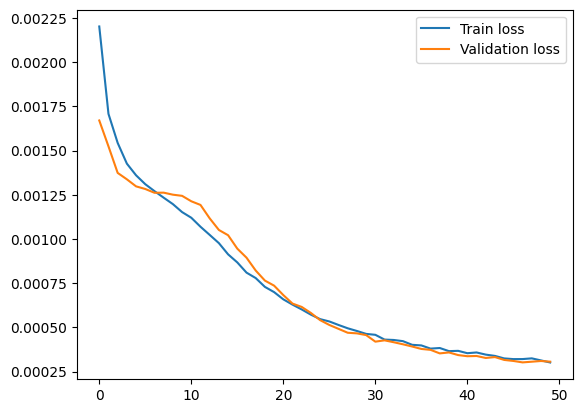

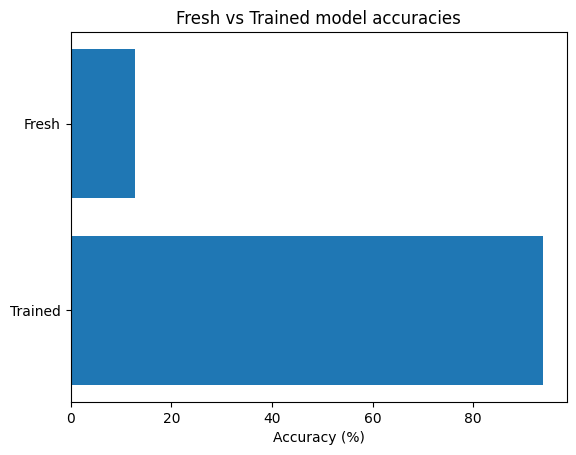

accuracy_trained,▁
train_loss,█▆▆▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▇▆▆▆▆▆▆▆▆▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
accuracy_trained,93.85001
train_loss,0.0003
valid_loss,0.00031


In [4]:
config_name = "classifier_12.yaml"
config = cfg.load_config(config_name)
default_dirs = cfg.get_default_dirs()
models_dir = Path(default_dirs["models_dir"])
datasets_dir = Path(default_dirs["datasets_dir"])


name = ''.join(random.choices(string.ascii_lowercase, k=7))
# Hyperparameters
hyperparameters = config["hyperparameters"]
epochs = hyperparameters["epochs"]
learning_rate = hyperparameters["learning_rate"]
seed = hyperparameters["seed"]

# Model config
model_config = config["model"]
input_dim = model_config["input_dim"]
hidden_dims = model_config["hidden_dims"]
output_dim = model_config["output_dim"]
dropout = model_config.get("dropout", 0.0)
use_batch_norm = model_config.get("use_batch_norm", False)
output_activation = model_config.get("output_activation", "softmax")


# Load dataset
dataset_config = config["dataset"]
dataset_name = dataset_config["name"]
dataset_splits = dataset_config["splits"]
batch_size = dataset_config["batch_size"]
dataset_seed = dataset_config["seed"]

dataset_path = datasets_dir / dataset_name
print(dataset_path)
# Create a dataset
dataset = ModelParamsDataset(dataset_path, 45)

torch.manual_seed(dataset_seed)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Split into train, validation and test sets
dataset_train, dataset_valid, dataset_test = torch.utils.data.random_split(dataset, dataset_splits)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataloader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=True)
dataloader_test = torch.utils.data.DataLoader(dataset_test)

print("Train sample:", len(dataset_train))
print("Validation sample:", len(dataset_valid))
print("Test sample:", len(dataset_test))


torch.manual_seed(seed)
wandb_config = dotenv_values("../.env")
wandb.init(project=wandb_config["WANDB_PROJECT"], entity=wandb_config["WANDB_ENTITY"], config=config, group="weight_classifier")

# Init
model = MLP(input_dim, hidden_dims, output_dim, dropout, use_batch_norm, output_activation)
model.to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_losses, valid_losses = trainer.train_mlp(model, epochs, learning_rate, criterion, optimizer, dataloader_train, dataloader_valid)

plt.plot(train_losses, label="Train loss")
plt.plot(valid_losses, label="Validation loss")
plt.legend()
plt.show()

# Check improvement compared to a fresh model
model_fresh = MLP(input_dim, hidden_dims, output_dim, dropout, use_batch_norm, output_activation)
accuracy_fresh = trainer.get_accuracy(model_fresh, dataloader_test)
accuracy_trained = trainer.get_accuracy(model, dataloader_test)

wandb.log({"accuracy_trained": accuracy_trained})

plt.title("Fresh vs Trained model accuracies")
plt.barh(["Trained", "Fresh"], [accuracy_trained, accuracy_fresh])
plt.xlabel("Accuracy (%)")
plt.show()

torch.save(model.state_dict(), models_dir / f"{name}.pth")
wandb.alert(title="Model training finished", text=f"Model [{config_name}] training finished successfully.")
wandb.finish()

C:\Projects\Python\master-thesis\data\eight_angles_pruned.csv
Train sample: 56000
Validation sample: 16000
Test sample: 8000


100%|██████████| 50/50 [09:39<00:00, 11.59s/it]


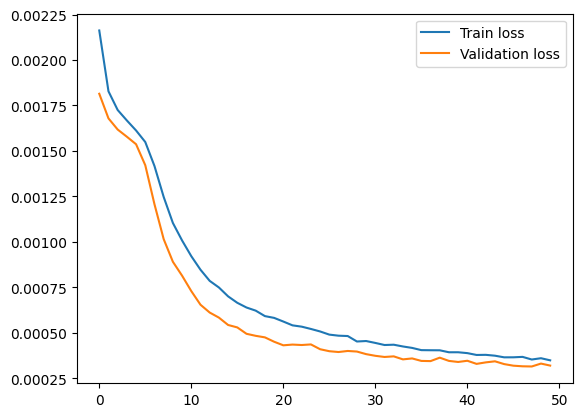

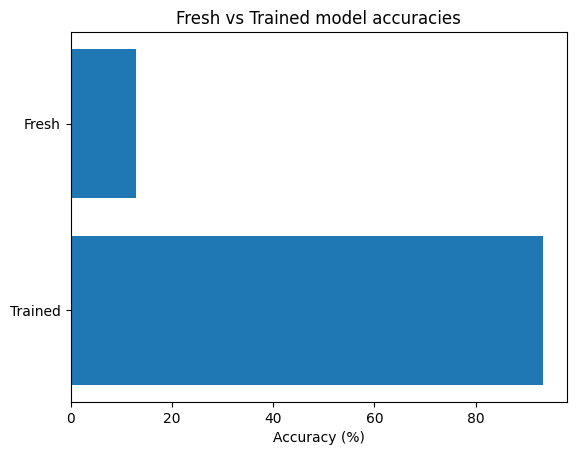

accuracy_trained,▁
train_loss,█▇▆▆▆▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▇▇▇▆▅▄▄▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy_trained,93.3
train_loss,0.00035
valid_loss,0.00032


In [6]:
config_name = "classifier_13.yaml"
config = cfg.load_config(config_name)
default_dirs = cfg.get_default_dirs()
models_dir = Path(default_dirs["models_dir"])
datasets_dir = Path(default_dirs["datasets_dir"])


name = ''.join(random.choices(string.ascii_lowercase, k=7))
# Hyperparameters
hyperparameters = config["hyperparameters"]
epochs = hyperparameters["epochs"]
learning_rate = hyperparameters["learning_rate"]
seed = hyperparameters["seed"]

# Model config
model_config = config["model"]
input_dim = model_config["input_dim"]
hidden_dims = model_config["hidden_dims"]
output_dim = model_config["output_dim"]
dropout = model_config.get("dropout", 0.0)
use_batch_norm = model_config.get("use_batch_norm", False)
output_activation = model_config.get("output_activation", "softmax")


# Load dataset
dataset_config = config["dataset"]
dataset_name = dataset_config["name"]
dataset_splits = dataset_config["splits"]
batch_size = dataset_config["batch_size"]
dataset_seed = dataset_config["seed"]

dataset_path = datasets_dir / dataset_name
print(dataset_path)
# Create a dataset
dataset = ModelParamsDataset(dataset_path, 45)

torch.manual_seed(dataset_seed)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Split into train, validation and test sets
dataset_train, dataset_valid, dataset_test = torch.utils.data.random_split(dataset, dataset_splits)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataloader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=True)
dataloader_test = torch.utils.data.DataLoader(dataset_test)

print("Train sample:", len(dataset_train))
print("Validation sample:", len(dataset_valid))
print("Test sample:", len(dataset_test))


torch.manual_seed(seed)
wandb_config = dotenv_values("../.env")
wandb.init(project=wandb_config["WANDB_PROJECT"], entity=wandb_config["WANDB_ENTITY"], config=config, group="weight_classifier")

# Init
model = MLP(input_dim, hidden_dims, output_dim, dropout, use_batch_norm, output_activation)
model.to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_losses, valid_losses = trainer.train_mlp(model, epochs, learning_rate, criterion, optimizer, dataloader_train, dataloader_valid)

plt.plot(train_losses, label="Train loss")
plt.plot(valid_losses, label="Validation loss")
plt.legend()
plt.show()

# Check improvement compared to a fresh model
model_fresh = MLP(input_dim, hidden_dims, output_dim, dropout, use_batch_norm, output_activation)
accuracy_fresh = trainer.get_accuracy(model_fresh, dataloader_test)
accuracy_trained = trainer.get_accuracy(model, dataloader_test)

wandb.log({"accuracy_trained": accuracy_trained})

plt.title("Fresh vs Trained model accuracies")
plt.barh(["Trained", "Fresh"], [accuracy_trained, accuracy_fresh])
plt.xlabel("Accuracy (%)")
plt.show()

torch.save(model.state_dict(), models_dir / f"{name}.pth")
wandb.alert(title="Model training finished", text=f"Model [{config_name}] training finished successfully.")
wandb.finish()

C:\Projects\Python\master-thesis\data\eight_angles_pruned_22.csv
Train sample: 56000
Validation sample: 16000
Test sample: 8000


100%|██████████| 50/50 [09:47<00:00, 11.76s/it]


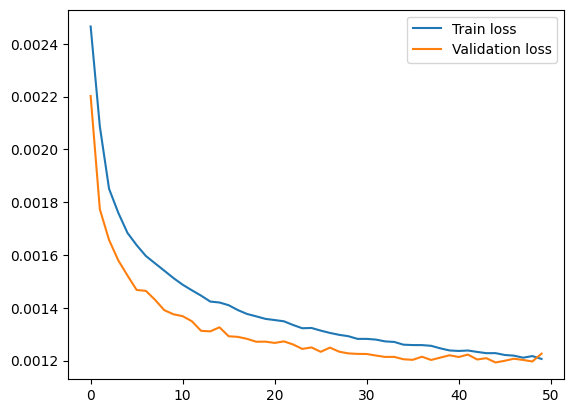

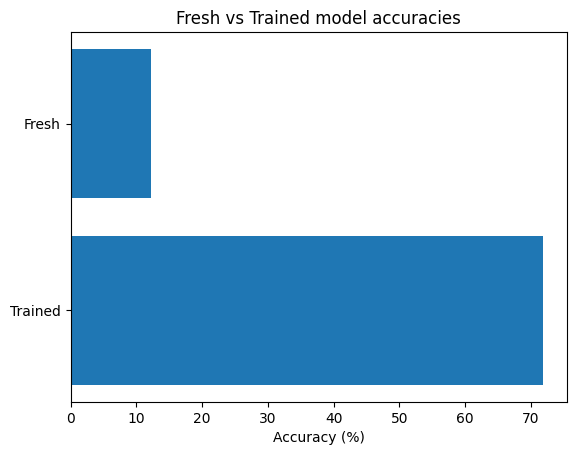

accuracy_trained,▁
train_loss,█▆▅▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy_trained,71.81251
train_loss,0.00121
valid_loss,0.00123


In [9]:
config_name = "classifier_14.yaml"
config = cfg.load_config(config_name)
default_dirs = cfg.get_default_dirs()
models_dir = Path(default_dirs["models_dir"])
datasets_dir = Path(default_dirs["datasets_dir"])


name = ''.join(random.choices(string.ascii_lowercase, k=7))
# Hyperparameters
hyperparameters = config["hyperparameters"]
epochs = hyperparameters["epochs"]
learning_rate = hyperparameters["learning_rate"]
seed = hyperparameters["seed"]

# Model config
model_config = config["model"]
input_dim = model_config["input_dim"]
hidden_dims = model_config["hidden_dims"]
output_dim = model_config["output_dim"]
dropout = model_config.get("dropout", 0.0)
use_batch_norm = model_config.get("use_batch_norm", False)
output_activation = model_config.get("output_activation", "softmax")


# Load dataset
dataset_config = config["dataset"]
dataset_name = dataset_config["name"]
dataset_splits = dataset_config["splits"]
batch_size = dataset_config["batch_size"]
dataset_seed = dataset_config["seed"]

dataset_path = datasets_dir / dataset_name
print(dataset_path)
# Create a dataset
dataset = ModelParamsDataset(dataset_path, 45)

torch.manual_seed(dataset_seed)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Split into train, validation and test sets
dataset_train, dataset_valid, dataset_test = torch.utils.data.random_split(dataset, dataset_splits)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataloader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=True)
dataloader_test = torch.utils.data.DataLoader(dataset_test)

print("Train sample:", len(dataset_train))
print("Validation sample:", len(dataset_valid))
print("Test sample:", len(dataset_test))


torch.manual_seed(seed)
wandb_config = dotenv_values("../.env")
wandb.init(project=wandb_config["WANDB_PROJECT"], entity=wandb_config["WANDB_ENTITY"], config=config, group="weight_classifier")

# Init
model = MLP(input_dim, hidden_dims, output_dim, dropout, use_batch_norm, output_activation)
model.to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_losses, valid_losses = trainer.train_mlp(model, epochs, learning_rate, criterion, optimizer, dataloader_train, dataloader_valid)

plt.plot(train_losses, label="Train loss")
plt.plot(valid_losses, label="Validation loss")
plt.legend()
plt.show()

# Check improvement compared to a fresh model
model_fresh = MLP(input_dim, hidden_dims, output_dim, dropout, use_batch_norm, output_activation)
accuracy_fresh = trainer.get_accuracy(model_fresh, dataloader_test)
accuracy_trained = trainer.get_accuracy(model, dataloader_test)

wandb.log({"accuracy_trained": accuracy_trained})

plt.title("Fresh vs Trained model accuracies")
plt.barh(["Trained", "Fresh"], [accuracy_trained, accuracy_fresh])
plt.xlabel("Accuracy (%)")
plt.show()

torch.save(model.state_dict(), models_dir / f"{name}.pth")
wandb.alert(title="Model training finished", text=f"Model [{config_name}] training finished successfully.")
wandb.finish()

C:\Projects\Python\master-thesis\data\eight_angles_pruned.csv
Train sample: 56000
Validation sample: 16000
Test sample: 8000


100%|██████████| 50/50 [11:16<00:00, 13.53s/it]


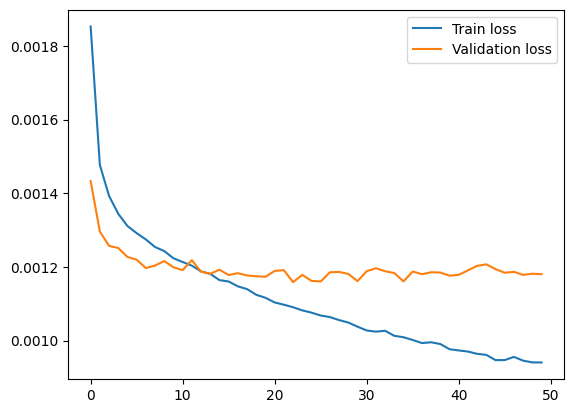

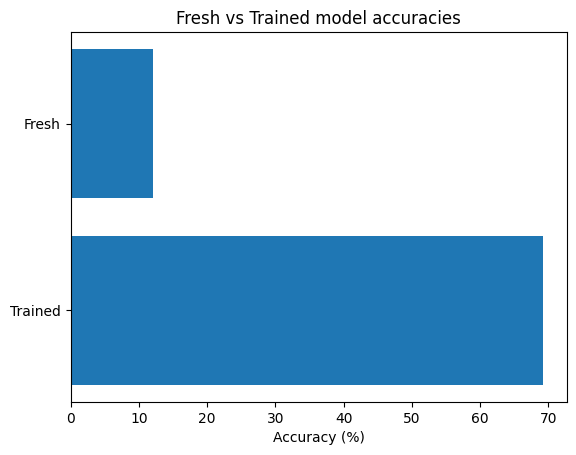

accuracy_trained,▁
train_loss,█▅▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▅▄▃▃▂▂▂▂▃▂▂▁▂▁▁▂▂▁▂▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
accuracy_trained,69.2
train_loss,0.00094
valid_loss,0.00118


In [4]:
config_name = "classifier_15.yaml"
config = cfg.load_config(config_name)
default_dirs = cfg.get_default_dirs()
models_dir = Path(default_dirs["models_dir"])
datasets_dir = Path(default_dirs["datasets_dir"])


name = ''.join(random.choices(string.ascii_lowercase, k=7))
# Hyperparameters
hyperparameters = config["hyperparameters"]
epochs = hyperparameters["epochs"]
learning_rate = hyperparameters["learning_rate"]
seed = hyperparameters["seed"]

# Model config
model_config = config["model"]
input_dim = model_config["input_dim"]
hidden_dims = model_config["hidden_dims"]
output_dim = model_config["output_dim"]
dropout = model_config.get("dropout", 0.0)
use_batch_norm = model_config.get("use_batch_norm", False)
output_activation = model_config.get("output_activation", "softmax")


# Load dataset
dataset_config = config["dataset"]
dataset_name = dataset_config["name"]
dataset_splits = dataset_config["splits"]
batch_size = dataset_config["batch_size"]
dataset_seed = dataset_config["seed"]

dataset_path = datasets_dir / dataset_name
print(dataset_path)
# Create a dataset
dataset = ModelParamsDataset(dataset_path, 45)

torch.manual_seed(dataset_seed)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Split into train, validation and test sets
dataset_train, dataset_valid, dataset_test = torch.utils.data.random_split(dataset, dataset_splits)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataloader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=True)
dataloader_test = torch.utils.data.DataLoader(dataset_test)

print("Train sample:", len(dataset_train))
print("Validation sample:", len(dataset_valid))
print("Test sample:", len(dataset_test))


torch.manual_seed(seed)
wandb_config = dotenv_values("../.env")
wandb.init(project=wandb_config["WANDB_PROJECT"], entity=wandb_config["WANDB_ENTITY"], config=config, group="weight_classifier")

# Init
model = MLP(input_dim, hidden_dims, output_dim, dropout, use_batch_norm, output_activation)
model.to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_losses, valid_losses = trainer.train_mlp(model, epochs, learning_rate, criterion, optimizer, dataloader_train, dataloader_valid)

plt.plot(train_losses, label="Train loss")
plt.plot(valid_losses, label="Validation loss")
plt.legend()
plt.show()

# Check improvement compared to a fresh model
model_fresh = MLP(input_dim, hidden_dims, output_dim, dropout, use_batch_norm, output_activation)
accuracy_fresh = trainer.get_accuracy(model_fresh, dataloader_test)
accuracy_trained = trainer.get_accuracy(model, dataloader_test)

wandb.log({"accuracy_trained": accuracy_trained})

plt.title("Fresh vs Trained model accuracies")
plt.barh(["Trained", "Fresh"], [accuracy_trained, accuracy_fresh])
plt.xlabel("Accuracy (%)")
plt.show()

torch.save(model.state_dict(), models_dir / f"{name}.pth")
wandb.alert(title="Model training finished", text=f"Model [{config_name}] training finished successfully.")
wandb.finish()

C:\Projects\Python\master-thesis\data\eight_angles_pruned.csv
Train sample: 56000
Validation sample: 16000
Test sample: 8000


100%|██████████| 50/50 [10:44<00:00, 12.88s/it]


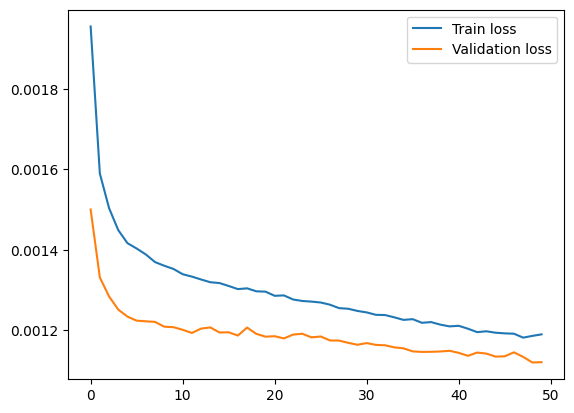

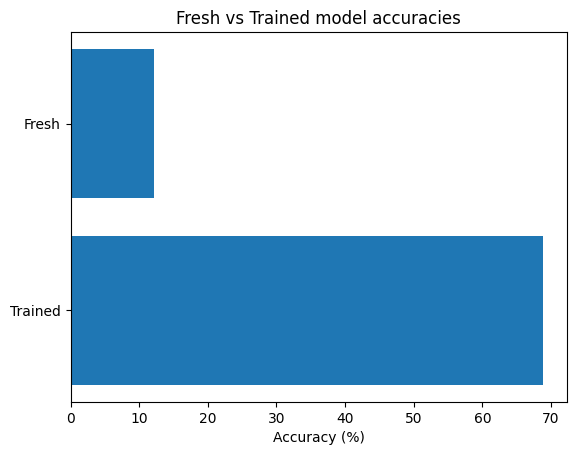

accuracy_trained,▁
train_loss,█▅▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▅▄▃▃▃▃▃▂▂▃▃▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
accuracy_trained,68.83751
train_loss,0.00119
valid_loss,0.00112


In [11]:
config_name = "classifier_16.yaml"
config = cfg.load_config(config_name)
default_dirs = cfg.get_default_dirs()
models_dir = Path(default_dirs["models_dir"])
datasets_dir = Path(default_dirs["datasets_dir"])


name = ''.join(random.choices(string.ascii_lowercase, k=7))
# Hyperparameters
hyperparameters = config["hyperparameters"]
epochs = hyperparameters["epochs"]
learning_rate = hyperparameters["learning_rate"]
seed = hyperparameters["seed"]

# Model config
model_config = config["model"]
input_dim = model_config["input_dim"]
hidden_dims = model_config["hidden_dims"]
output_dim = model_config["output_dim"]
dropout = model_config.get("dropout", 0.0)
use_batch_norm = model_config.get("use_batch_norm", False)
output_activation = model_config.get("output_activation", "softmax")


# Load dataset
dataset_config = config["dataset"]
dataset_name = dataset_config["name"]
dataset_splits = dataset_config["splits"]
batch_size = dataset_config["batch_size"]
dataset_seed = dataset_config["seed"]

dataset_path = datasets_dir / dataset_name
print(dataset_path)
# Create a dataset
dataset = ModelParamsDataset(dataset_path, 45)

torch.manual_seed(dataset_seed)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Split into train, validation and test sets
dataset_train, dataset_valid, dataset_test = torch.utils.data.random_split(dataset, dataset_splits)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataloader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=True)
dataloader_test = torch.utils.data.DataLoader(dataset_test)

print("Train sample:", len(dataset_train))
print("Validation sample:", len(dataset_valid))
print("Test sample:", len(dataset_test))


torch.manual_seed(seed)
wandb_config = dotenv_values("../.env")
wandb.init(project=wandb_config["WANDB_PROJECT"], entity=wandb_config["WANDB_ENTITY"], config=config, group="weight_classifier")

# Init
model = MLP(input_dim, hidden_dims, output_dim, dropout, use_batch_norm, output_activation)
model.to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_losses, valid_losses = trainer.train_mlp(model, epochs, learning_rate, criterion, optimizer, dataloader_train, dataloader_valid)

plt.plot(train_losses, label="Train loss")
plt.plot(valid_losses, label="Validation loss")
plt.legend()
plt.show()

# Check improvement compared to a fresh model
model_fresh = MLP(input_dim, hidden_dims, output_dim, dropout, use_batch_norm, output_activation)
accuracy_fresh = trainer.get_accuracy(model_fresh, dataloader_test)
accuracy_trained = trainer.get_accuracy(model, dataloader_test)

wandb.log({"accuracy_trained": accuracy_trained})

plt.title("Fresh vs Trained model accuracies")
plt.barh(["Trained", "Fresh"], [accuracy_trained, accuracy_fresh])
plt.xlabel("Accuracy (%)")
plt.show()

torch.save(model.state_dict(), models_dir / f"{name}.pth")
wandb.alert(title="Model training finished", text=f"Model [{config_name}] training finished successfully.")
wandb.finish()

C:\Projects\Python\master-thesis\data\eight_angles_pruned.csv


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Train sample: 56000
Validation sample: 16000
Test sample: 8000


wandb: Currently logged in as: idavron (idavron-team). Use `wandb login --relogin` to force relogin


100%|██████████| 50/50 [13:34<00:00, 16.29s/it]


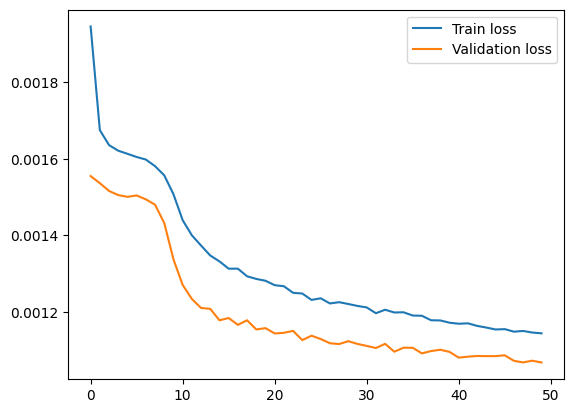

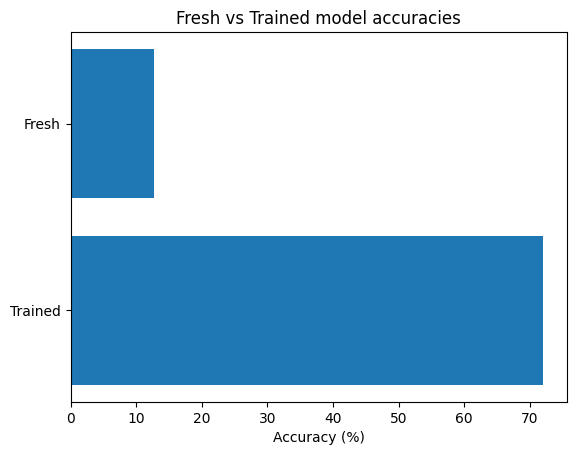

accuracy_trained,▁
train_loss,█▆▅▅▅▅▅▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,██▇▇▇▇▇▆▄▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁
accuracy_trained,72.025
train_loss,0.00114
valid_loss,0.00107


In [6]:
config_name = "classifier_17.yaml"
config = cfg.load_config(config_name)
default_dirs = cfg.get_default_dirs()
models_dir = Path(default_dirs["models_dir"])
datasets_dir = Path(default_dirs["datasets_dir"])


name = ''.join(random.choices(string.ascii_lowercase, k=7))
# Hyperparameters
hyperparameters = config["hyperparameters"]
epochs = hyperparameters["epochs"]
learning_rate = hyperparameters["learning_rate"]
seed = hyperparameters["seed"]

# Model config
model_config = config["model"]
input_dim = model_config["input_dim"]
hidden_dims = model_config["hidden_dims"]
output_dim = model_config["output_dim"]
dropout = model_config.get("dropout", 0.0)
use_batch_norm = model_config.get("use_batch_norm", False)
output_activation = model_config.get("output_activation", "softmax")


# Load dataset
dataset_config = config["dataset"]
dataset_name = dataset_config["name"]
dataset_splits = dataset_config["splits"]
batch_size = dataset_config["batch_size"]
dataset_seed = dataset_config["seed"]

dataset_path = datasets_dir / dataset_name
print(dataset_path)
# Create a dataset
dataset = ModelParamsDataset(dataset_path, 45)

torch.manual_seed(dataset_seed)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Split into train, validation and test sets
dataset_train, dataset_valid, dataset_test = torch.utils.data.random_split(dataset, dataset_splits)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataloader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=True)
dataloader_test = torch.utils.data.DataLoader(dataset_test)

print("Train sample:", len(dataset_train))
print("Validation sample:", len(dataset_valid))
print("Test sample:", len(dataset_test))


torch.manual_seed(seed)
wandb_config = dotenv_values("../.env")
wandb.init(project=wandb_config["WANDB_PROJECT"], entity=wandb_config["WANDB_ENTITY"], config=config, group="weight_classifier")

# Init
model = MLP(input_dim, hidden_dims, output_dim, dropout, use_batch_norm, output_activation)
model.to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_losses, valid_losses = trainer.train_mlp(model, epochs, learning_rate, criterion, optimizer, dataloader_train, dataloader_valid)

plt.plot(train_losses, label="Train loss")
plt.plot(valid_losses, label="Validation loss")
plt.legend()
plt.show()

# Check improvement compared to a fresh model
model_fresh = MLP(input_dim, hidden_dims, output_dim, dropout, use_batch_norm, output_activation)
accuracy_fresh = trainer.get_accuracy(model_fresh, dataloader_test)
accuracy_trained = trainer.get_accuracy(model, dataloader_test)

wandb.log({"accuracy_trained": accuracy_trained})

plt.title("Fresh vs Trained model accuracies")
plt.barh(["Trained", "Fresh"], [accuracy_trained, accuracy_fresh])
plt.xlabel("Accuracy (%)")
plt.show()

torch.save(model.state_dict(), models_dir / f"{name}.pth")
wandb.alert(title="Model training finished", text=f"Model [{config_name}] training finished successfully.")
wandb.finish()

C:\Projects\Python\master-thesis\data\eight_angles.csv


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Train sample: 56000
Validation sample: 16000
Test sample: 8000


wandb: Currently logged in as: idavron (idavron-team). Use `wandb login --relogin` to force relogin


100%|██████████| 50/50 [09:59<00:00, 11.98s/it]


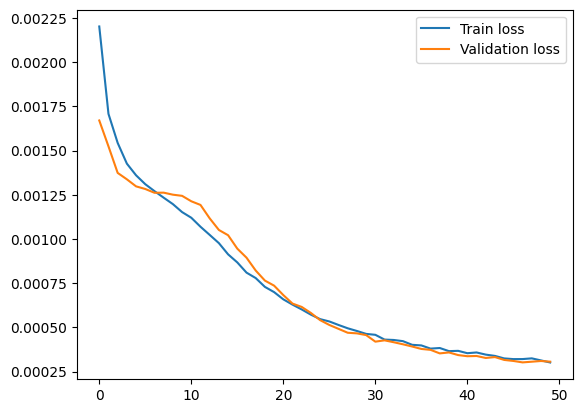

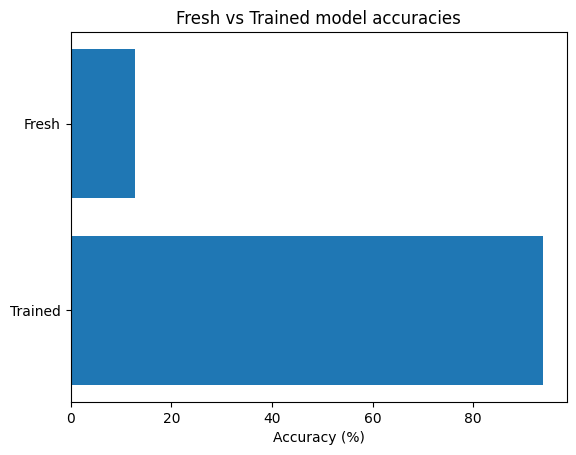

accuracy_trained,▁
train_loss,█▆▆▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▇▆▆▆▆▆▆▆▆▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
accuracy_trained,93.85001
train_loss,0.0003
valid_loss,0.00031


In [3]:
config_name = "classifier_12.yaml"
config = cfg.load_config(config_name)
default_dirs = cfg.get_default_dirs()
models_dir = Path(default_dirs["models_dir"])
datasets_dir = Path(default_dirs["datasets_dir"])


name = ''.join(random.choices(string.ascii_lowercase, k=7))
name = config["name"]
# Hyperparameters
hyperparameters = config["hyperparameters"]
epochs = hyperparameters["epochs"]
learning_rate = hyperparameters["learning_rate"]
seed = hyperparameters["seed"]

# Model config
model_config = config["model"]
input_dim = model_config["input_dim"]
hidden_dims = model_config["hidden_dims"]
output_dim = model_config["output_dim"]
dropout = model_config.get("dropout", 0.0)
use_batch_norm = model_config.get("use_batch_norm", False)
output_activation = model_config.get("output_activation", "softmax")


# Load dataset
dataset_config = config["dataset"]
dataset_name = dataset_config["name"]
dataset_splits = dataset_config["splits"]
batch_size = dataset_config["batch_size"]
dataset_seed = dataset_config["seed"]

dataset_path = datasets_dir / dataset_name
print(dataset_path)
# Create a dataset
dataset = ModelParamsDataset(dataset_path, 45)

torch.manual_seed(dataset_seed)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Split into train, validation and test sets
dataset_train, dataset_valid, dataset_test = torch.utils.data.random_split(dataset, dataset_splits)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataloader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=True)
dataloader_test = torch.utils.data.DataLoader(dataset_test)

print("Train sample:", len(dataset_train))
print("Validation sample:", len(dataset_valid))
print("Test sample:", len(dataset_test))


torch.manual_seed(seed)
wandb_config = dotenv_values("../.env")
wandb.init(project=wandb_config["WANDB_PROJECT"], entity=wandb_config["WANDB_ENTITY"], config=config, group="weight_classifier")

# Init
model = MLP(input_dim, hidden_dims, output_dim, dropout, use_batch_norm, output_activation)
model.to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_losses, valid_losses = trainer.train_mlp(model, epochs, learning_rate, criterion, optimizer, dataloader_train, dataloader_valid)

plt.plot(train_losses, label="Train loss")
plt.plot(valid_losses, label="Validation loss")
plt.legend()
plt.show()

# Check improvement compared to a fresh model
model_fresh = MLP(input_dim, hidden_dims, output_dim, dropout, use_batch_norm, output_activation)
accuracy_fresh = trainer.get_accuracy(model_fresh, dataloader_test)
accuracy_trained = trainer.get_accuracy(model, dataloader_test)

wandb.log({"accuracy_trained": accuracy_trained})

plt.title("Fresh vs Trained model accuracies")
plt.barh(["Trained", "Fresh"], [accuracy_trained, accuracy_fresh])
plt.xlabel("Accuracy (%)")
plt.show()

torch.save(model.state_dict(), models_dir / f"{name}.pth")
wandb.alert(title="Model training finished", text=f"Model [{config_name}] training finished successfully.")
wandb.finish()

C:\Projects\Python\master-thesis\data\eight_angles_masked.csv
Train sample: 56000
Validation sample: 16000
Test sample: 8000


100%|██████████| 50/50 [09:48<00:00, 11.77s/it]


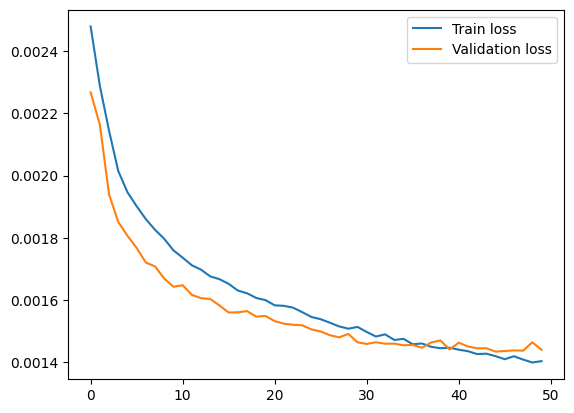

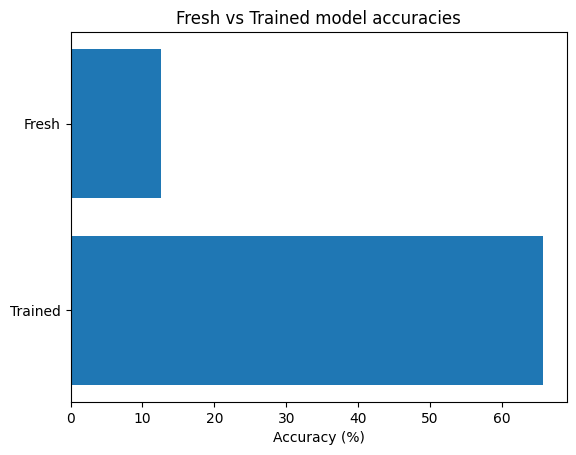

accuracy_trained,▁
train_loss,█▇▆▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▇▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy_trained,65.72501
train_loss,0.0014
valid_loss,0.00144


In [6]:
config_name = "classifier_19.yaml"
config = cfg.load_config(config_name)
default_dirs = cfg.get_default_dirs()
models_dir = Path(default_dirs["models_dir"])
datasets_dir = Path(default_dirs["datasets_dir"])


name = ''.join(random.choices(string.ascii_lowercase, k=7))
name = config["name"]
# Hyperparameters
hyperparameters = config["hyperparameters"]
epochs = hyperparameters["epochs"]
learning_rate = hyperparameters["learning_rate"]
seed = hyperparameters["seed"]

# Model config
model_config = config["model"]
input_dim = model_config["input_dim"]
hidden_dims = model_config["hidden_dims"]
output_dim = model_config["output_dim"]
dropout = model_config.get("dropout", 0.0)
use_batch_norm = model_config.get("use_batch_norm", False)
output_activation = model_config.get("output_activation", "softmax")


# Load dataset
dataset_config = config["dataset"]
dataset_name = dataset_config["name"]
dataset_splits = dataset_config["splits"]
batch_size = dataset_config["batch_size"]
dataset_seed = dataset_config["seed"]

dataset_path = datasets_dir / dataset_name
print(dataset_path)
# Create a dataset
dataset = ModelParamsDataset(dataset_path, 45)

torch.manual_seed(dataset_seed)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Split into train, validation and test sets
dataset_train, dataset_valid, dataset_test = torch.utils.data.random_split(dataset, dataset_splits)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataloader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=True)
dataloader_test = torch.utils.data.DataLoader(dataset_test)

print("Train sample:", len(dataset_train))
print("Validation sample:", len(dataset_valid))
print("Test sample:", len(dataset_test))


torch.manual_seed(seed)
wandb_config = dotenv_values("../.env")
wandb.init(project=wandb_config["WANDB_PROJECT"], entity=wandb_config["WANDB_ENTITY"], config=config, group="weight_classifier")

# Init
model = MLP(input_dim, hidden_dims, output_dim, dropout, use_batch_norm, output_activation)
model.to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_losses, valid_losses = trainer.train_mlp(model, epochs, learning_rate, criterion, optimizer, dataloader_train, dataloader_valid)

plt.plot(train_losses, label="Train loss")
plt.plot(valid_losses, label="Validation loss")
plt.legend()
plt.show()

# Check improvement compared to a fresh model
model_fresh = MLP(input_dim, hidden_dims, output_dim, dropout, use_batch_norm, output_activation)
accuracy_fresh = trainer.get_accuracy(model_fresh, dataloader_test)
accuracy_trained = trainer.get_accuracy(model, dataloader_test)

wandb.log({"accuracy_trained": accuracy_trained})

plt.title("Fresh vs Trained model accuracies")
plt.barh(["Trained", "Fresh"], [accuracy_trained, accuracy_fresh])
plt.xlabel("Accuracy (%)")
plt.show()

torch.save(model.state_dict(), models_dir / f"{name}.pth")
wandb.alert(title="Model training finished", text=f"Model [{config_name}] training finished successfully.")
wandb.finish()

C:\Projects\Python\master-thesis\data\eight_angles_masked.csv
Train sample: 56000
Validation sample: 16000
Test sample: 8000


100%|██████████| 200/200 [44:19<00:00, 13.30s/it]


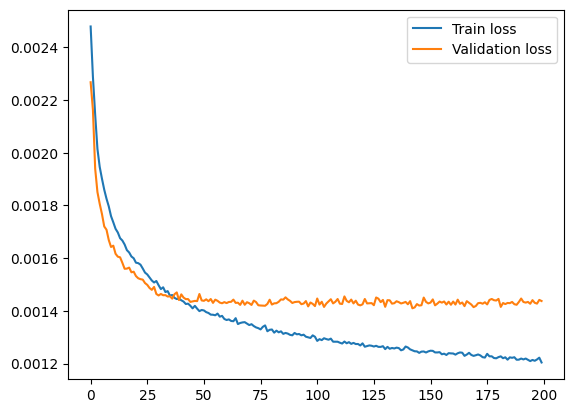

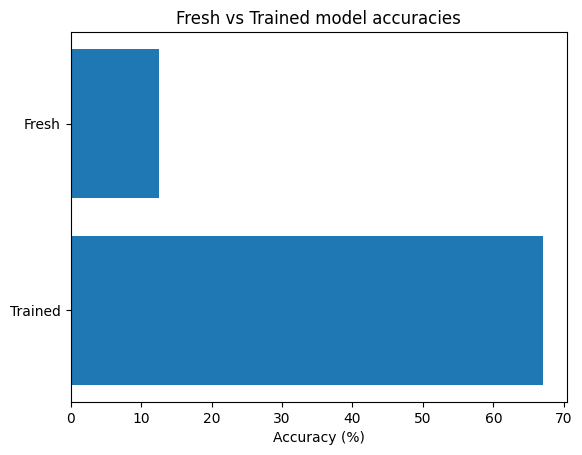

accuracy_trained,▁
train_loss,█▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy_trained,67.03751
train_loss,0.0012
valid_loss,0.00144


In [7]:
config_name = "classifier_20.yaml"
config = cfg.load_config(config_name)
default_dirs = cfg.get_default_dirs()
models_dir = Path(default_dirs["models_dir"])
datasets_dir = Path(default_dirs["datasets_dir"])


name = ''.join(random.choices(string.ascii_lowercase, k=7))
name = config["name"]
# Hyperparameters
hyperparameters = config["hyperparameters"]
epochs = hyperparameters["epochs"]
learning_rate = hyperparameters["learning_rate"]
seed = hyperparameters["seed"]

# Model config
model_config = config["model"]
input_dim = model_config["input_dim"]
hidden_dims = model_config["hidden_dims"]
output_dim = model_config["output_dim"]
dropout = model_config.get("dropout", 0.0)
use_batch_norm = model_config.get("use_batch_norm", False)
output_activation = model_config.get("output_activation", "softmax")


# Load dataset
dataset_config = config["dataset"]
dataset_name = dataset_config["name"]
dataset_splits = dataset_config["splits"]
batch_size = dataset_config["batch_size"]
dataset_seed = dataset_config["seed"]

dataset_path = datasets_dir / dataset_name
print(dataset_path)
# Create a dataset
dataset = ModelParamsDataset(dataset_path, 45)

torch.manual_seed(dataset_seed)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Split into train, validation and test sets
dataset_train, dataset_valid, dataset_test = torch.utils.data.random_split(dataset, dataset_splits)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataloader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=True)
dataloader_test = torch.utils.data.DataLoader(dataset_test)

print("Train sample:", len(dataset_train))
print("Validation sample:", len(dataset_valid))
print("Test sample:", len(dataset_test))


torch.manual_seed(seed)
wandb_config = dotenv_values("../.env")
wandb.init(project=wandb_config["WANDB_PROJECT"], entity=wandb_config["WANDB_ENTITY"], config=config, group="weight_classifier")

# Init
model = MLP(input_dim, hidden_dims, output_dim, dropout, use_batch_norm, output_activation)
model.to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_losses, valid_losses = trainer.train_mlp(model, epochs, learning_rate, criterion, optimizer, dataloader_train, dataloader_valid)

plt.plot(train_losses, label="Train loss")
plt.plot(valid_losses, label="Validation loss")
plt.legend()
plt.show()

# Check improvement compared to a fresh model
model_fresh = MLP(input_dim, hidden_dims, output_dim, dropout, use_batch_norm, output_activation)
accuracy_fresh = trainer.get_accuracy(model_fresh, dataloader_test)
accuracy_trained = trainer.get_accuracy(model, dataloader_test)

wandb.log({"accuracy_trained": accuracy_trained})

plt.title("Fresh vs Trained model accuracies")
plt.barh(["Trained", "Fresh"], [accuracy_trained, accuracy_fresh])
plt.xlabel("Accuracy (%)")
plt.show()

torch.save(model.state_dict(), models_dir / f"{name}.pth")
wandb.alert(title="Model training finished", text=f"Model [{config_name}] training finished successfully.")
wandb.finish()

C:\Projects\Python\master-thesis\data\eight_angles_masked.csv
Train sample: 56000
Validation sample: 16000
Test sample: 8000


100%|██████████| 200/200 [50:45<00:00, 15.23s/it]


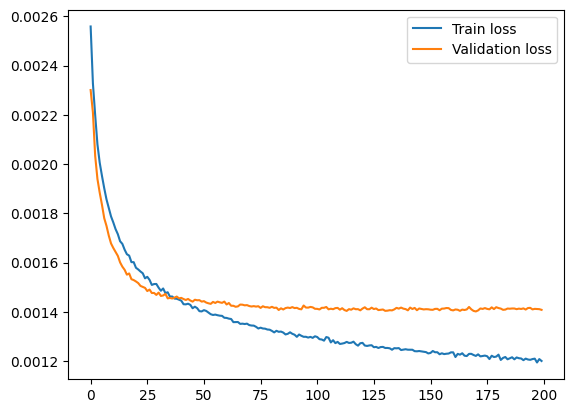

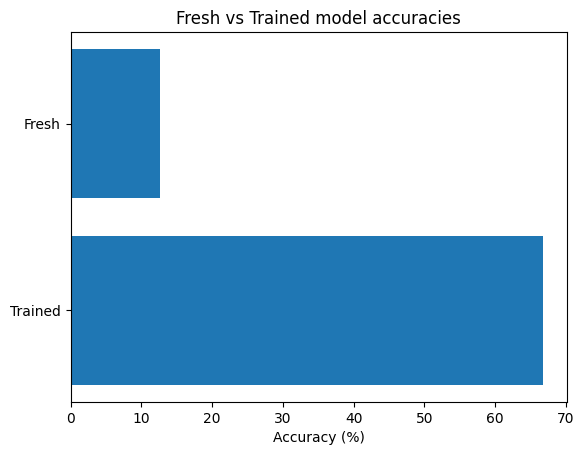

accuracy_trained,▁
train_loss,█▆▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▅▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy_trained,66.7625
train_loss,0.0012
valid_loss,0.00141


In [8]:
config_name = "classifier_21.yaml"
config = cfg.load_config(config_name)
default_dirs = cfg.get_default_dirs()
models_dir = Path(default_dirs["models_dir"])
datasets_dir = Path(default_dirs["datasets_dir"])


name = ''.join(random.choices(string.ascii_lowercase, k=7))
name = config["name"]
# Hyperparameters
hyperparameters = config["hyperparameters"]
epochs = hyperparameters["epochs"]
learning_rate = hyperparameters["learning_rate"]
seed = hyperparameters["seed"]

# Model config
model_config = config["model"]
input_dim = model_config["input_dim"]
hidden_dims = model_config["hidden_dims"]
output_dim = model_config["output_dim"]
dropout = model_config.get("dropout", 0.0)
use_batch_norm = model_config.get("use_batch_norm", False)
output_activation = model_config.get("output_activation", "softmax")


# Load dataset
dataset_config = config["dataset"]
dataset_name = dataset_config["name"]
dataset_splits = dataset_config["splits"]
batch_size = dataset_config["batch_size"]
dataset_seed = dataset_config["seed"]

dataset_path = datasets_dir / dataset_name
print(dataset_path)
# Create a dataset
dataset = ModelParamsDataset(dataset_path, 45)

torch.manual_seed(dataset_seed)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Split into train, validation and test sets
dataset_train, dataset_valid, dataset_test = torch.utils.data.random_split(dataset, dataset_splits)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataloader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=True)
dataloader_test = torch.utils.data.DataLoader(dataset_test)

print("Train sample:", len(dataset_train))
print("Validation sample:", len(dataset_valid))
print("Test sample:", len(dataset_test))


torch.manual_seed(seed)
wandb_config = dotenv_values("../.env")
wandb.init(project=wandb_config["WANDB_PROJECT"], entity=wandb_config["WANDB_ENTITY"], config=config, group="weight_classifier")

# Init
model = MLP(input_dim, hidden_dims, output_dim, dropout, use_batch_norm, output_activation)
model.to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_losses, valid_losses = trainer.train_mlp(model, epochs, learning_rate, criterion, optimizer, dataloader_train, dataloader_valid)

plt.plot(train_losses, label="Train loss")
plt.plot(valid_losses, label="Validation loss")
plt.legend()
plt.show()

# Check improvement compared to a fresh model
model_fresh = MLP(input_dim, hidden_dims, output_dim, dropout, use_batch_norm, output_activation)
accuracy_fresh = trainer.get_accuracy(model_fresh, dataloader_test)
accuracy_trained = trainer.get_accuracy(model, dataloader_test)

wandb.log({"accuracy_trained": accuracy_trained})

plt.title("Fresh vs Trained model accuracies")
plt.barh(["Trained", "Fresh"], [accuracy_trained, accuracy_fresh])
plt.xlabel("Accuracy (%)")
plt.show()

torch.save(model.state_dict(), models_dir / f"{name}.pth")
wandb.alert(title="Model training finished", text=f"Model [{config_name}] training finished successfully.")
wandb.finish()

C:\Projects\Python\master-thesis\data\eight_angles_fc1.csv
Train sample: 56000
Validation sample: 16000
Test sample: 8000


100%|██████████| 200/200 [49:50<00:00, 14.95s/it]


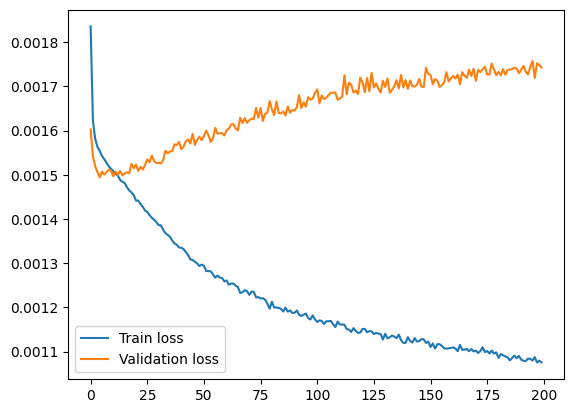

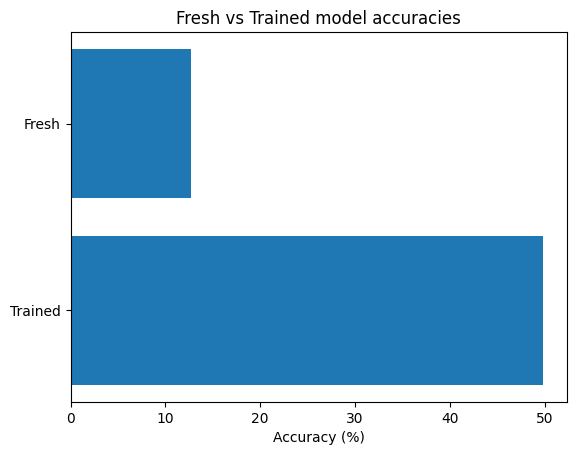

accuracy_trained,▁
train_loss,█▇▆▆▆▅▅▅▄▄▄▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁
valid_loss,▂▁▁▁▁▂▂▂▃▄▄▄▄▄▄▅▅▅▅▆▅▆▆▆▆▆▆▇▇▇▇▇▇███▇█▇█
accuracy_trained,49.825
train_loss,0.00108
valid_loss,0.00174


In [10]:
config_name = "classifier_22.yaml"
config = cfg.load_config(config_name)
print("Config loaded:\n", config)

default_dirs = cfg.get_default_dirs()
models_dir = Path(default_dirs["models_dir"])
datasets_dir = Path(default_dirs["datasets_dir"])

name = ''.join(random.choices(string.ascii_lowercase, k=7))
name = config["name"]
# Hyperparameters
hyperparameters = config["hyperparameters"]
epochs = hyperparameters["epochs"]
learning_rate = hyperparameters["learning_rate"]
seed = hyperparameters["seed"]

# Model config
model_config = config["model"]
input_dim = model_config["input_dim"]
hidden_dims = model_config["hidden_dims"]
output_dim = model_config["output_dim"]
dropout = model_config.get("dropout", 0.0)
use_batch_norm = model_config.get("use_batch_norm", False)
output_activation = model_config.get("output_activation", "softmax")

# Load dataset
dataset_config = config["dataset"]
dataset_name = dataset_config["name"]
dataset_splits = dataset_config["splits"]
batch_size = dataset_config["batch_size"]
dataset_seed = dataset_config["seed"]

dataset_path = datasets_dir / dataset_name
print(dataset_path)
# Create a dataset
dataset = ModelParamsDataset(dataset_path, 45)

torch.manual_seed(dataset_seed)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Split into train, validation and test sets
dataset_train, dataset_valid, dataset_test = torch.utils.data.random_split(dataset, dataset_splits)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataloader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=True)
dataloader_test = torch.utils.data.DataLoader(dataset_test)

print("Train sample:", len(dataset_train))
print("Validation sample:", len(dataset_valid))
print("Test sample:", len(dataset_test))


torch.manual_seed(seed)
wandb_config = dotenv_values("../.env")
wandb.init(project=wandb_config["WANDB_PROJECT"], entity=wandb_config["WANDB_ENTITY"], config=config, group="weight_classifier")

# Init
model = MLP(input_dim, hidden_dims, output_dim, dropout, use_batch_norm, output_activation)
model.to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_losses, valid_losses = trainer.train_mlp(model, epochs, learning_rate, criterion, optimizer, dataloader_train, dataloader_valid)

plt.plot(train_losses, label="Train loss")
plt.plot(valid_losses, label="Validation loss")
plt.legend()
plt.show()

# Check improvement compared to a fresh model
model_fresh = MLP(input_dim, hidden_dims, output_dim, dropout, use_batch_norm, output_activation)
accuracy_fresh = trainer.get_accuracy(model_fresh, dataloader_test)
accuracy_trained = trainer.get_accuracy(model, dataloader_test)

wandb.log({"accuracy_trained": accuracy_trained})

plt.title("Fresh vs Trained model accuracies")
plt.barh(["Trained", "Fresh"], [accuracy_trained, accuracy_fresh])
plt.xlabel("Accuracy (%)")
plt.show()

torch.save(model.state_dict(), models_dir / f"{name}.pth")
wandb.alert(title="Model training finished", text=f"Model [{config_name}] training finished successfully.")
wandb.finish()

Config loaded:
 {'name': 'classifier_23', 'dataset': {'name': 'eight_angles_fc1.csv', 'splits': [0.7, 0.2, 0.1], 'batch_size': 128, 'seed': 42}, 'hyperparameters': {'epochs': 50, 'learning_rate': 0.005, 'optimizer': 'adam', 'criterion': 'bce', 'seed': 42}, 'model': {'input_dim': 30, 'hidden_dims': [400, 200], 'output_dim': 8, 'use_batch_norm': True, 'dropout': 0.2, 'output_activation': 'softmax'}}
C:\Projects\Python\master-thesis\data\eight_angles_fc1.csv
Train sample: 56000
Validation sample: 16000
Test sample: 8000


100%|██████████| 50/50 [11:49<00:00, 14.19s/it]


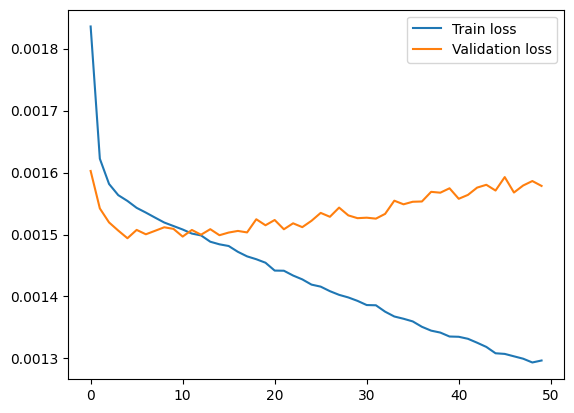

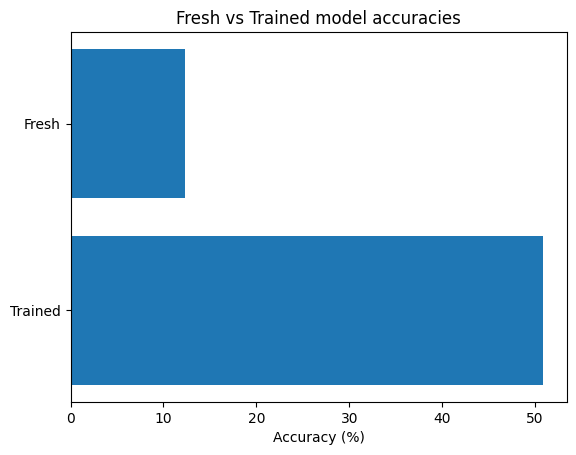

accuracy_trained,▁
train_loss,█▅▅▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
valid_loss,█▄▃▂▂▁▂▂▁▂▁▂▁▂▁▃▃▂▂▂▄▃▄▃▃▃▃▅▅▅▆▆▅▅▆▇▇▆▆▆
accuracy_trained,50.8625
train_loss,0.0013
valid_loss,0.00158


In [13]:
config_name = "classifier_23.yaml"
config = cfg.load_config(config_name)
print("Config loaded:\n", config)

default_dirs = cfg.get_default_dirs()
models_dir = Path(default_dirs["models_dir"])
datasets_dir = Path(default_dirs["datasets_dir"])

name = ''.join(random.choices(string.ascii_lowercase, k=7))
name = config["name"]
# Hyperparameters
hyperparameters = config["hyperparameters"]
epochs = hyperparameters["epochs"]
learning_rate = hyperparameters["learning_rate"]
seed = hyperparameters["seed"]

# Model config
model_config = config["model"]
input_dim = model_config["input_dim"]
hidden_dims = model_config["hidden_dims"]
output_dim = model_config["output_dim"]
dropout = model_config.get("dropout", 0.0)
use_batch_norm = model_config.get("use_batch_norm", False)
output_activation = model_config.get("output_activation", "softmax")

# Load dataset
dataset_config = config["dataset"]
dataset_name = dataset_config["name"]
dataset_splits = dataset_config["splits"]
batch_size = dataset_config["batch_size"]
dataset_seed = dataset_config["seed"]

dataset_path = datasets_dir / dataset_name
print(dataset_path)
# Create a dataset
dataset = ModelParamsDataset(dataset_path, 45)

torch.manual_seed(dataset_seed)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Split into train, validation and test sets
dataset_train, dataset_valid, dataset_test = torch.utils.data.random_split(dataset, dataset_splits)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataloader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=True)
dataloader_test = torch.utils.data.DataLoader(dataset_test)

print("Train sample:", len(dataset_train))
print("Validation sample:", len(dataset_valid))
print("Test sample:", len(dataset_test))


torch.manual_seed(seed)
wandb_config = dotenv_values("../.env")
wandb.init(project=wandb_config["WANDB_PROJECT"], entity=wandb_config["WANDB_ENTITY"], config=config, group="weight_classifier")

# Init
model = MLP(input_dim, hidden_dims, output_dim, dropout, use_batch_norm, output_activation)
model.to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_losses, valid_losses = trainer.train_mlp(model, epochs, learning_rate, criterion, optimizer, dataloader_train, dataloader_valid)

plt.plot(train_losses, label="Train loss")
plt.plot(valid_losses, label="Validation loss")
plt.legend()
plt.show()

# Check improvement compared to a fresh model
model_fresh = MLP(input_dim, hidden_dims, output_dim, dropout, use_batch_norm, output_activation)
accuracy_fresh = trainer.get_accuracy(model_fresh, dataloader_test)
accuracy_trained = trainer.get_accuracy(model, dataloader_test)

wandb.log({"accuracy_trained": accuracy_trained})

plt.title("Fresh vs Trained model accuracies")
plt.barh(["Trained", "Fresh"], [accuracy_trained, accuracy_fresh])
plt.xlabel("Accuracy (%)")
plt.show()

torch.save(model.state_dict(), models_dir / f"{name}.pth")
wandb.alert(title="Model training finished", text=f"Model [{config_name}] training finished successfully.")
wandb.finish()

Config loaded:
 {'name': 'classifier_23', 'dataset': {'name': 'test_dataset.csv', 'splits': [0.7, 0.2, 0.1], 'batch_size': 128, 'seed': 42}, 'hyperparameters': {'epochs': 50, 'learning_rate': 0.005, 'optimizer': 'adam', 'criterion': 'bce', 'seed': 42}, 'model': {'input_dim': 94, 'hidden_dims': [400, 200], 'output_dim': 8, 'use_batch_norm': True, 'dropout': 0.2, 'output_activation': 'softmax'}}
C:\Projects\Python\master-thesis\data\test_dataset.csv
Train sample: 56000
Validation sample: 16000
Test sample: 8000


100%|██████████| 50/50 [09:55<00:00, 11.91s/it]


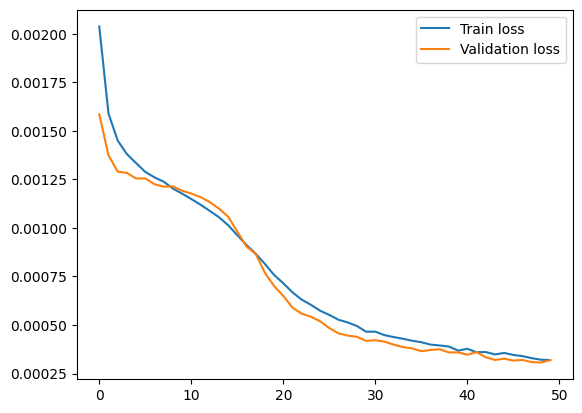

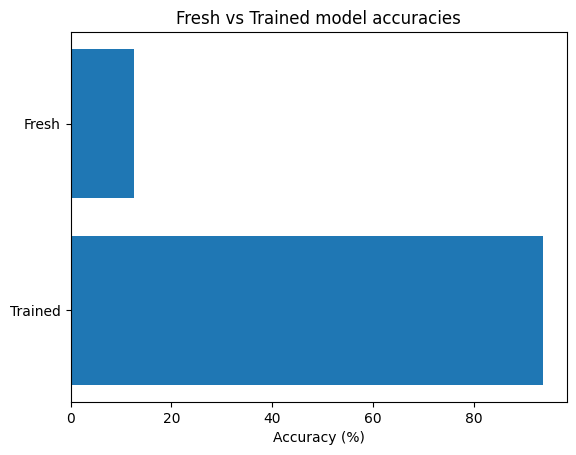

accuracy_trained,▁
train_loss,█▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▇▆▆▆▆▆▆▆▆▆▅▅▄▄▄▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy_trained,93.675
train_loss,0.00032
valid_loss,0.00032


In [14]:
config_name = "classifier_24.yaml"
config = cfg.load_config(config_name)
print("Config loaded:\n", config)

default_dirs = cfg.get_default_dirs()
models_dir = Path(default_dirs["models_dir"])
datasets_dir = Path(default_dirs["datasets_dir"])

name = ''.join(random.choices(string.ascii_lowercase, k=7))
name = config["name"]
# Hyperparameters
hyperparameters = config["hyperparameters"]
epochs = hyperparameters["epochs"]
learning_rate = hyperparameters["learning_rate"]
seed = hyperparameters["seed"]

# Model config
model_config = config["model"]
input_dim = model_config["input_dim"]
hidden_dims = model_config["hidden_dims"]
output_dim = model_config["output_dim"]
dropout = model_config.get("dropout", 0.0)
use_batch_norm = model_config.get("use_batch_norm", False)
output_activation = model_config.get("output_activation", "softmax")

# Load dataset
dataset_config = config["dataset"]
dataset_name = dataset_config["name"]
dataset_splits = dataset_config["splits"]
batch_size = dataset_config["batch_size"]
dataset_seed = dataset_config["seed"]

dataset_path = datasets_dir / dataset_name
print(dataset_path)
# Create a dataset
dataset = ModelParamsDataset(dataset_path, 45)

torch.manual_seed(dataset_seed)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Split into train, validation and test sets
dataset_train, dataset_valid, dataset_test = torch.utils.data.random_split(dataset, dataset_splits)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataloader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=True)
dataloader_test = torch.utils.data.DataLoader(dataset_test)

print("Train sample:", len(dataset_train))
print("Validation sample:", len(dataset_valid))
print("Test sample:", len(dataset_test))


torch.manual_seed(seed)
wandb_config = dotenv_values("../.env")
wandb.init(project=wandb_config["WANDB_PROJECT"], entity=wandb_config["WANDB_ENTITY"], config=config, group="weight_classifier")

# Init
model = MLP(input_dim, hidden_dims, output_dim, dropout, use_batch_norm, output_activation)
model.to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_losses, valid_losses = trainer.train_mlp(model, epochs, learning_rate, criterion, optimizer, dataloader_train, dataloader_valid)

plt.plot(train_losses, label="Train loss")
plt.plot(valid_losses, label="Validation loss")
plt.legend()
plt.show()

# Check improvement compared to a fresh model
model_fresh = MLP(input_dim, hidden_dims, output_dim, dropout, use_batch_norm, output_activation)
accuracy_fresh = trainer.get_accuracy(model_fresh, dataloader_test)
accuracy_trained = trainer.get_accuracy(model, dataloader_test)

wandb.log({"accuracy_trained": accuracy_trained})

plt.title("Fresh vs Trained model accuracies")
plt.barh(["Trained", "Fresh"], [accuracy_trained, accuracy_fresh])
plt.xlabel("Accuracy (%)")
plt.show()

torch.save(model.state_dict(), models_dir / f"{name}.pth")
wandb.alert(title="Model training finished", text=f"Model [{config_name}] training finished successfully.")
wandb.finish()

Config loaded:
 {'name': 'classifier_24', 'dataset': {'name': 'test_dataset_2.csv', 'splits': [0.7, 0.2, 0.1], 'batch_size': 128, 'seed': 42}, 'hyperparameters': {'epochs': 50, 'learning_rate': 0.005, 'optimizer': 'adam', 'criterion': 'bce', 'seed': 42}, 'model': {'input_dim': 41, 'hidden_dims': [400, 200], 'output_dim': 8, 'use_batch_norm': True, 'dropout': 0.2, 'output_activation': 'softmax'}}
C:\Projects\Python\master-thesis\data\test_dataset_2.csv
Train sample: 56000
Validation sample: 16000
Test sample: 8000


100%|██████████| 50/50 [09:45<00:00, 11.71s/it]


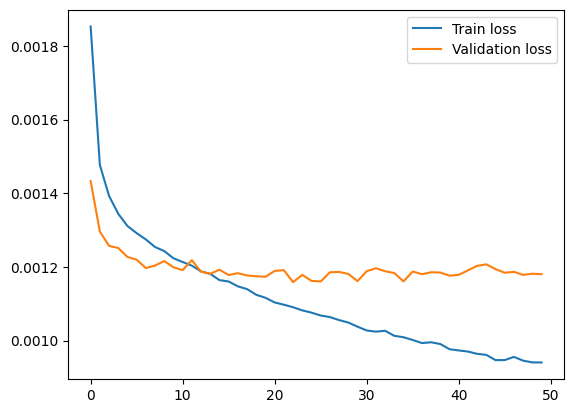

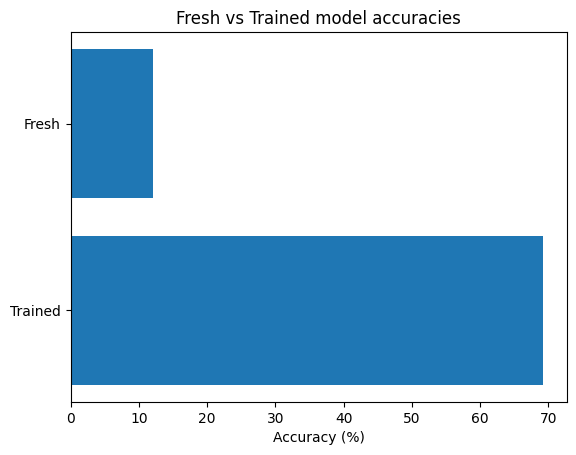

accuracy_trained,▁
train_loss,█▅▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▅▄▃▃▂▂▂▂▃▂▂▁▂▁▁▂▂▁▂▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
accuracy_trained,69.2
train_loss,0.00094
valid_loss,0.00118


In [16]:
config_name = "classifier_25.yaml"
config = cfg.load_config(config_name)
print("Config loaded:\n", config)

default_dirs = cfg.get_default_dirs()
models_dir = Path(default_dirs["models_dir"])
datasets_dir = Path(default_dirs["datasets_dir"])

name = ''.join(random.choices(string.ascii_lowercase, k=7))
name = config["name"]
# Hyperparameters
hyperparameters = config["hyperparameters"]
epochs = hyperparameters["epochs"]
learning_rate = hyperparameters["learning_rate"]
seed = hyperparameters["seed"]

# Model config
model_config = config["model"]
input_dim = model_config["input_dim"]
hidden_dims = model_config["hidden_dims"]
output_dim = model_config["output_dim"]
dropout = model_config.get("dropout", 0.0)
use_batch_norm = model_config.get("use_batch_norm", False)
output_activation = model_config.get("output_activation", "softmax")

# Load dataset
dataset_config = config["dataset"]
dataset_name = dataset_config["name"]
dataset_splits = dataset_config["splits"]
batch_size = dataset_config["batch_size"]
dataset_seed = dataset_config["seed"]

dataset_path = datasets_dir / dataset_name
print(dataset_path)
# Create a dataset
dataset = ModelParamsDataset(dataset_path, 45)

torch.manual_seed(dataset_seed)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Split into train, validation and test sets
dataset_train, dataset_valid, dataset_test = torch.utils.data.random_split(dataset, dataset_splits)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataloader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=True)
dataloader_test = torch.utils.data.DataLoader(dataset_test)

print("Train sample:", len(dataset_train))
print("Validation sample:", len(dataset_valid))
print("Test sample:", len(dataset_test))


torch.manual_seed(seed)
wandb_config = dotenv_values("../.env")
wandb.init(project=wandb_config["WANDB_PROJECT"], entity=wandb_config["WANDB_ENTITY"], config=config, group="weight_classifier")

# Init
model = MLP(input_dim, hidden_dims, output_dim, dropout, use_batch_norm, output_activation)
model.to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_losses, valid_losses = trainer.train_mlp(model, epochs, learning_rate, criterion, optimizer, dataloader_train, dataloader_valid)

plt.plot(train_losses, label="Train loss")
plt.plot(valid_losses, label="Validation loss")
plt.legend()
plt.show()

# Check improvement compared to a fresh model
model_fresh = MLP(input_dim, hidden_dims, output_dim, dropout, use_batch_norm, output_activation)
accuracy_fresh = trainer.get_accuracy(model_fresh, dataloader_test)
accuracy_trained = trainer.get_accuracy(model, dataloader_test)

wandb.log({"accuracy_trained": accuracy_trained})

plt.title("Fresh vs Trained model accuracies")
plt.barh(["Trained", "Fresh"], [accuracy_trained, accuracy_fresh])
plt.xlabel("Accuracy (%)")
plt.show()

torch.save(model.state_dict(), models_dir / f"{name}.pth")
wandb.alert(title="Model training finished", text=f"Model [{config_name}] training finished successfully.\n Accuracy: {accuracy_trained}")
wandb.finish()

Config loaded:
 {'name': 'classifier_26', 'dataset': {'name': 'test_dataset_3.csv', 'splits': [0.7, 0.2, 0.1], 'batch_size': 128, 'seed': 42}, 'hyperparameters': {'epochs': 50, 'learning_rate': 0.005, 'optimizer': 'adam', 'criterion': 'bce', 'seed': 42}, 'model': {'input_dim': 53, 'hidden_dims': [400, 200], 'output_dim': 8, 'use_batch_norm': True, 'dropout': 0.2, 'output_activation': 'softmax'}}
C:\Projects\Python\master-thesis\data\test_dataset_3.csv
Train sample: 56000
Validation sample: 16000
Test sample: 8000


100%|██████████| 50/50 [09:47<00:00, 11.74s/it]


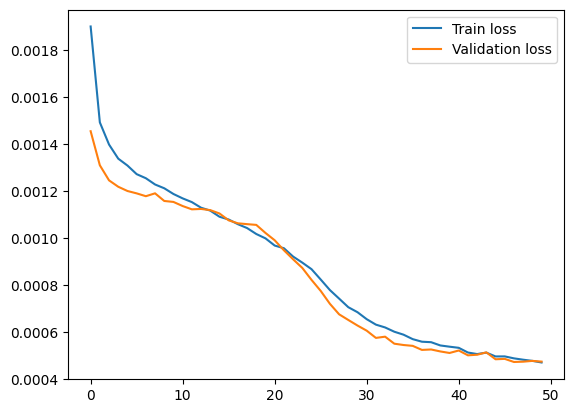

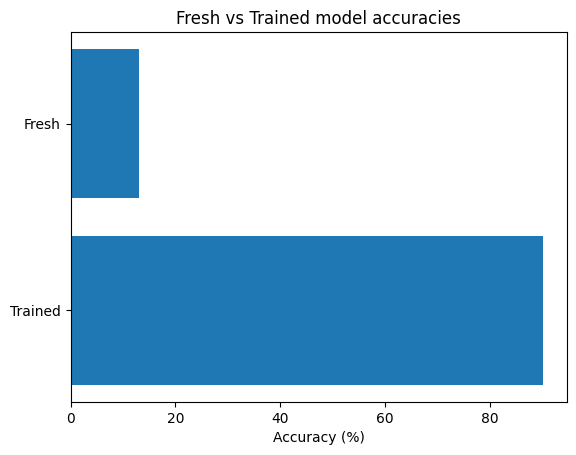

accuracy_trained,▁
train_loss,█▆▆▅▅▅▅▅▄▄▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▇▇▆▆▆▆▆▆▆▆▆▅▅▅▅▅▄▄▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
accuracy_trained,90.1125
train_loss,0.00047
valid_loss,0.00048


In [17]:
config_name = "classifier_26.yaml"
config = cfg.load_config(config_name)
print("Config loaded:\n", config)

default_dirs = cfg.get_default_dirs()
models_dir = Path(default_dirs["models_dir"])
datasets_dir = Path(default_dirs["datasets_dir"])

name = ''.join(random.choices(string.ascii_lowercase, k=7))
name = config["name"]
# Hyperparameters
hyperparameters = config["hyperparameters"]
epochs = hyperparameters["epochs"]
learning_rate = hyperparameters["learning_rate"]
seed = hyperparameters["seed"]

# Model config
model_config = config["model"]
input_dim = model_config["input_dim"]
hidden_dims = model_config["hidden_dims"]
output_dim = model_config["output_dim"]
dropout = model_config.get("dropout", 0.0)
use_batch_norm = model_config.get("use_batch_norm", False)
output_activation = model_config.get("output_activation", "softmax")

# Load dataset
dataset_config = config["dataset"]
dataset_name = dataset_config["name"]
dataset_splits = dataset_config["splits"]
batch_size = dataset_config["batch_size"]
dataset_seed = dataset_config["seed"]

dataset_path = datasets_dir / dataset_name
print(dataset_path)
# Create a dataset
dataset = ModelParamsDataset(dataset_path, 45)

torch.manual_seed(dataset_seed)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Split into train, validation and test sets
dataset_train, dataset_valid, dataset_test = torch.utils.data.random_split(dataset, dataset_splits)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataloader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=True)
dataloader_test = torch.utils.data.DataLoader(dataset_test)

print("Train sample:", len(dataset_train))
print("Validation sample:", len(dataset_valid))
print("Test sample:", len(dataset_test))


torch.manual_seed(seed)
wandb_config = dotenv_values("../.env")
wandb.init(project=wandb_config["WANDB_PROJECT"], entity=wandb_config["WANDB_ENTITY"], config=config, group="weight_classifier")

# Init
model = MLP(input_dim, hidden_dims, output_dim, dropout, use_batch_norm, output_activation)
model.to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_losses, valid_losses = trainer.train_mlp(model, epochs, learning_rate, criterion, optimizer, dataloader_train, dataloader_valid)

plt.plot(train_losses, label="Train loss")
plt.plot(valid_losses, label="Validation loss")
plt.legend()
plt.show()

# Check improvement compared to a fresh model
model_fresh = MLP(input_dim, hidden_dims, output_dim, dropout, use_batch_norm, output_activation)
accuracy_fresh = trainer.get_accuracy(model_fresh, dataloader_test)
accuracy_trained = trainer.get_accuracy(model, dataloader_test)

wandb.log({"accuracy_trained": accuracy_trained})

plt.title("Fresh vs Trained model accuracies")
plt.barh(["Trained", "Fresh"], [accuracy_trained, accuracy_fresh])
plt.xlabel("Accuracy (%)")
plt.show()

torch.save(model.state_dict(), models_dir / f"{name}.pth")
wandb.alert(title="Model training finished", text=f"Model [{config_name}] training finished successfully.\n Accuracy: {accuracy_trained}")
wandb.finish()

Config loaded:
 {'name': 'classifier_27', 'dataset': {'name': 'test_dataset_4.csv', 'splits': [0.7, 0.2, 0.1], 'batch_size': 128, 'seed': 42}, 'hyperparameters': {'epochs': 50, 'learning_rate': 0.005, 'optimizer': 'adam', 'criterion': 'bce', 'seed': 42}, 'model': {'input_dim': 51, 'hidden_dims': [400, 200], 'output_dim': 8, 'use_batch_norm': True, 'dropout': 0.2, 'output_activation': 'softmax'}}
C:\Projects\Python\master-thesis\data\test_dataset_4.csv
Train sample: 56000
Validation sample: 16000
Test sample: 8000


100%|██████████| 50/50 [09:51<00:00, 11.84s/it]


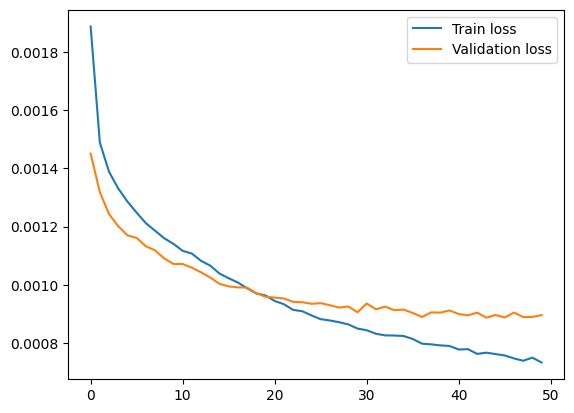

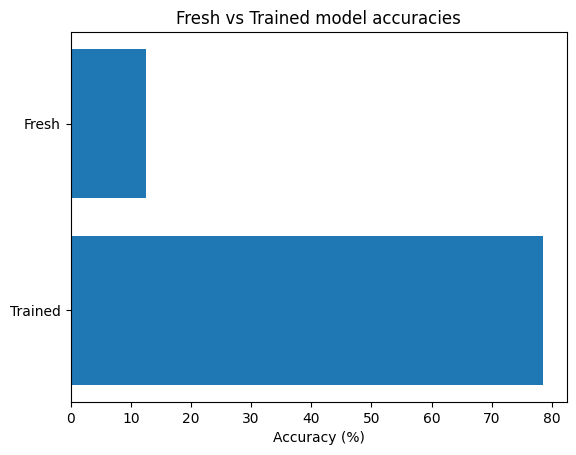

accuracy_trained,▁
train_loss,█▆▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▆▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy_trained,78.5125
train_loss,0.00073
valid_loss,0.0009


In [18]:
config_name = "classifier_27.yaml"
config = cfg.load_config(config_name)
print("Config loaded:\n", config)

default_dirs = cfg.get_default_dirs()
models_dir = Path(default_dirs["models_dir"])
datasets_dir = Path(default_dirs["datasets_dir"])

name = ''.join(random.choices(string.ascii_lowercase, k=7))
name = config["name"]
# Hyperparameters
hyperparameters = config["hyperparameters"]
epochs = hyperparameters["epochs"]
learning_rate = hyperparameters["learning_rate"]
seed = hyperparameters["seed"]

# Model config
model_config = config["model"]
input_dim = model_config["input_dim"]
hidden_dims = model_config["hidden_dims"]
output_dim = model_config["output_dim"]
dropout = model_config.get("dropout", 0.0)
use_batch_norm = model_config.get("use_batch_norm", False)
output_activation = model_config.get("output_activation", "softmax")

# Load dataset
dataset_config = config["dataset"]
dataset_name = dataset_config["name"]
dataset_splits = dataset_config["splits"]
batch_size = dataset_config["batch_size"]
dataset_seed = dataset_config["seed"]

dataset_path = datasets_dir / dataset_name
print(dataset_path)
# Create a dataset
dataset = ModelParamsDataset(dataset_path, 45)

torch.manual_seed(dataset_seed)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Split into train, validation and test sets
dataset_train, dataset_valid, dataset_test = torch.utils.data.random_split(dataset, dataset_splits)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataloader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=True)
dataloader_test = torch.utils.data.DataLoader(dataset_test)

print("Train sample:", len(dataset_train))
print("Validation sample:", len(dataset_valid))
print("Test sample:", len(dataset_test))


torch.manual_seed(seed)
wandb_config = dotenv_values("../.env")
wandb.init(project=wandb_config["WANDB_PROJECT"], entity=wandb_config["WANDB_ENTITY"], config=config, group="weight_classifier")

# Init
model = MLP(input_dim, hidden_dims, output_dim, dropout, use_batch_norm, output_activation)
model.to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_losses, valid_losses = trainer.train_mlp(model, epochs, learning_rate, criterion, optimizer, dataloader_train, dataloader_valid)

plt.plot(train_losses, label="Train loss")
plt.plot(valid_losses, label="Validation loss")
plt.legend()
plt.show()

# Check improvement compared to a fresh model
model_fresh = MLP(input_dim, hidden_dims, output_dim, dropout, use_batch_norm, output_activation)
accuracy_fresh = trainer.get_accuracy(model_fresh, dataloader_test)
accuracy_trained = trainer.get_accuracy(model, dataloader_test)

wandb.log({"accuracy_trained": accuracy_trained})

plt.title("Fresh vs Trained model accuracies")
plt.barh(["Trained", "Fresh"], [accuracy_trained, accuracy_fresh])
plt.xlabel("Accuracy (%)")
plt.show()

torch.save(model.state_dict(), models_dir / f"{name}.pth")
wandb.alert(title="Model training finished", text=f"Model [{config_name}] training finished successfully.\n Accuracy: {accuracy_trained}")
wandb.finish()

Config loaded:
 {'name': 'classifier_26', 'dataset': {'name': 'test_dataset_3.csv', 'splits': [0.7, 0.2, 0.1], 'batch_size': 128, 'seed': 42}, 'hyperparameters': {'epochs': 50, 'learning_rate': 0.005, 'optimizer': 'adam', 'criterion': 'bce', 'seed': 42}, 'model': {'input_dim': 53, 'hidden_dims': [400, 200], 'output_dim': 8, 'use_batch_norm': True, 'dropout': 0.2, 'output_activation': 'softmax'}}
C:\Projects\Python\master-thesis\data\test_dataset_3.csv
Train sample: 56000
Validation sample: 16000
Test sample: 8000


100%|██████████| 50/50 [09:56<00:00, 11.92s/it]


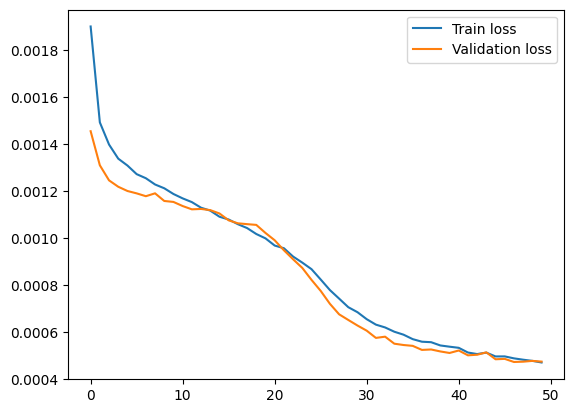

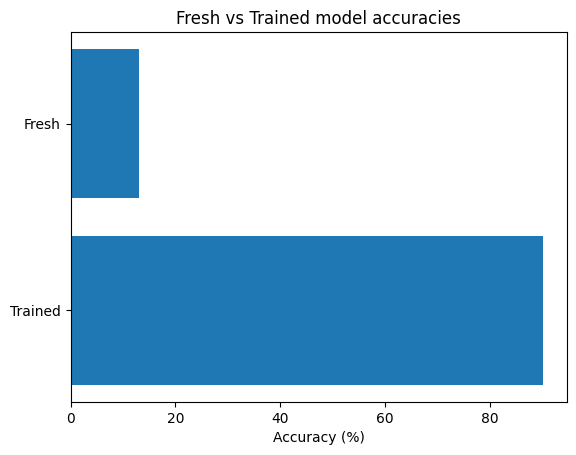

accuracy_trained,▁
train_loss,█▆▆▅▅▅▅▅▄▄▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▇▇▆▆▆▆▆▆▆▆▆▅▅▅▅▅▄▄▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
accuracy_trained,90.1125
train_loss,0.00047
valid_loss,0.00048


In [19]:
config_name = "classifier_28.yaml"
config = cfg.load_config(config_name)
print("Config loaded:\n", config)

default_dirs = cfg.get_default_dirs()
models_dir = Path(default_dirs["models_dir"])
datasets_dir = Path(default_dirs["datasets_dir"])

name = ''.join(random.choices(string.ascii_lowercase, k=7))
name = config["name"]
# Hyperparameters
hyperparameters = config["hyperparameters"]
epochs = hyperparameters["epochs"]
learning_rate = hyperparameters["learning_rate"]
seed = hyperparameters["seed"]

# Model config
model_config = config["model"]
input_dim = model_config["input_dim"]
hidden_dims = model_config["hidden_dims"]
output_dim = model_config["output_dim"]
dropout = model_config.get("dropout", 0.0)
use_batch_norm = model_config.get("use_batch_norm", False)
output_activation = model_config.get("output_activation", "softmax")

# Load dataset
dataset_config = config["dataset"]
dataset_name = dataset_config["name"]
dataset_splits = dataset_config["splits"]
batch_size = dataset_config["batch_size"]
dataset_seed = dataset_config["seed"]

dataset_path = datasets_dir / dataset_name
print(dataset_path)
# Create a dataset
dataset = ModelParamsDataset(dataset_path, 45)

torch.manual_seed(dataset_seed)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Split into train, validation and test sets
dataset_train, dataset_valid, dataset_test = torch.utils.data.random_split(dataset, dataset_splits)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataloader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=True)
dataloader_test = torch.utils.data.DataLoader(dataset_test)

print("Train sample:", len(dataset_train))
print("Validation sample:", len(dataset_valid))
print("Test sample:", len(dataset_test))


torch.manual_seed(seed)
wandb_config = dotenv_values("../.env")
wandb.init(project=wandb_config["WANDB_PROJECT"], entity=wandb_config["WANDB_ENTITY"], config=config, group="weight_classifier")

# Init
model = MLP(input_dim, hidden_dims, output_dim, dropout, use_batch_norm, output_activation)
model.to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_losses, valid_losses = trainer.train_mlp(model, epochs, learning_rate, criterion, optimizer, dataloader_train, dataloader_valid)

plt.plot(train_losses, label="Train loss")
plt.plot(valid_losses, label="Validation loss")
plt.legend()
plt.show()

# Check improvement compared to a fresh model
model_fresh = MLP(input_dim, hidden_dims, output_dim, dropout, use_batch_norm, output_activation)
accuracy_fresh = trainer.get_accuracy(model_fresh, dataloader_test)
accuracy_trained = trainer.get_accuracy(model, dataloader_test)

wandb.log({"accuracy_trained": accuracy_trained})

plt.title("Fresh vs Trained model accuracies")
plt.barh(["Trained", "Fresh"], [accuracy_trained, accuracy_fresh])
plt.xlabel("Accuracy (%)")
plt.show()

torch.save(model.state_dict(), models_dir / f"{name}.pth")
wandb.alert(title="Model training finished", text=f"Model [{config_name}] training finished successfully.\n Accuracy: {accuracy_trained}")
wandb.finish()

Config loaded:
 {'name': 'classifier_29', 'dataset': {'name': 'test_dataset_6.csv', 'splits': [0.7, 0.2, 0.1], 'batch_size': 128, 'seed': 42}, 'hyperparameters': {'epochs': 50, 'learning_rate': 0.005, 'optimizer': 'adam', 'criterion': 'bce', 'seed': 42}, 'model': {'input_dim': 71, 'hidden_dims': [400, 200], 'output_dim': 8, 'use_batch_norm': True, 'dropout': 0.2, 'output_activation': 'softmax'}}
C:\Projects\Python\master-thesis\data\test_dataset_6.csv
Train sample: 56000
Validation sample: 16000
Test sample: 8000


100%|██████████| 50/50 [10:12<00:00, 12.25s/it]


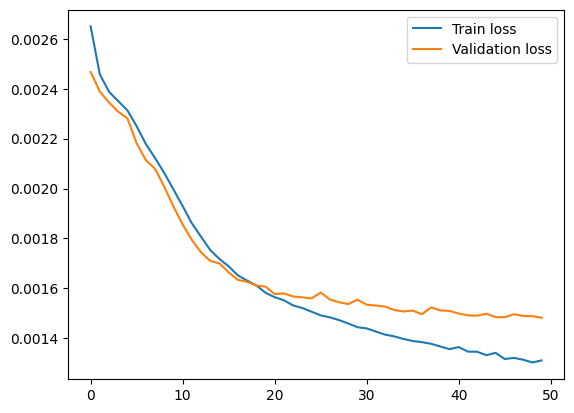

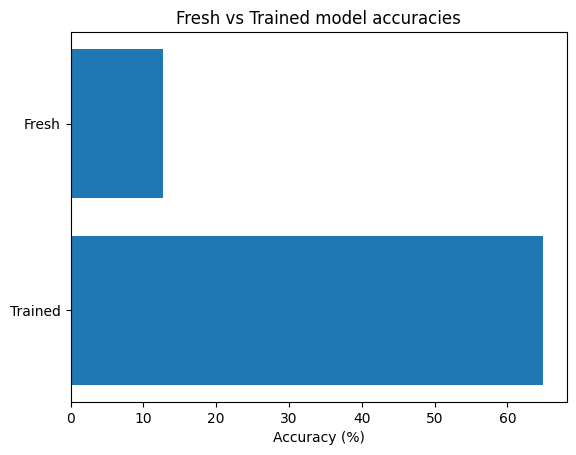

accuracy_trained,▁
train_loss,█▇▇▆▆▆▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▇▇▇▆▅▅▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy_trained,64.8875
train_loss,0.00131
valid_loss,0.00148


In [30]:
config_name = "classifier_29.yaml"
config = cfg.load_config(config_name)
print("Config loaded:\n", config)

default_dirs = cfg.get_default_dirs()
models_dir = Path(default_dirs["models_dir"])
datasets_dir = Path(default_dirs["datasets_dir"])

name = ''.join(random.choices(string.ascii_lowercase, k=7))
name = config["name"]
# Hyperparameters
hyperparameters = config["hyperparameters"]
epochs = hyperparameters["epochs"]
learning_rate = hyperparameters["learning_rate"]
seed = hyperparameters["seed"]

# Model config
model_config = config["model"]
input_dim = model_config["input_dim"]
hidden_dims = model_config["hidden_dims"]
output_dim = model_config["output_dim"]
dropout = model_config.get("dropout", 0.0)
use_batch_norm = model_config.get("use_batch_norm", False)
output_activation = model_config.get("output_activation", "softmax")

# Load dataset
dataset_config = config["dataset"]
dataset_name = dataset_config["name"]
dataset_splits = dataset_config["splits"]
batch_size = dataset_config["batch_size"]
dataset_seed = dataset_config["seed"]

dataset_path = datasets_dir / dataset_name
print(dataset_path)
# Create a dataset
dataset = ModelParamsDataset(dataset_path, 45)

torch.manual_seed(dataset_seed)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Split into train, validation and test sets
dataset_train, dataset_valid, dataset_test = torch.utils.data.random_split(dataset, dataset_splits)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataloader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=True)
dataloader_test = torch.utils.data.DataLoader(dataset_test)

print("Train sample:", len(dataset_train))
print("Validation sample:", len(dataset_valid))
print("Test sample:", len(dataset_test))


torch.manual_seed(seed)
wandb_config = dotenv_values("../.env")
wandb.init(project=wandb_config["WANDB_PROJECT"], entity=wandb_config["WANDB_ENTITY"], config=config, group="weight_classifier")

# Init
model = MLP(input_dim, hidden_dims, output_dim, dropout, use_batch_norm, output_activation)
model.to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_losses, valid_losses = trainer.train_mlp(model, epochs, learning_rate, criterion, optimizer, dataloader_train, dataloader_valid)

plt.plot(train_losses, label="Train loss")
plt.plot(valid_losses, label="Validation loss")
plt.legend()
plt.show()

# Check improvement compared to a fresh model
model_fresh = MLP(input_dim, hidden_dims, output_dim, dropout, use_batch_norm, output_activation)
accuracy_fresh = trainer.get_accuracy(model_fresh, dataloader_test)
accuracy_trained = trainer.get_accuracy(model, dataloader_test)

wandb.log({"accuracy_trained": accuracy_trained})

plt.title("Fresh vs Trained model accuracies")
plt.barh(["Trained", "Fresh"], [accuracy_trained, accuracy_fresh])
plt.xlabel("Accuracy (%)")
plt.show()

torch.save(model.state_dict(), models_dir / f"{name}.pth")
wandb.alert(title="Model training finished", text=f"Model [{config_name}] training finished successfully.\n Accuracy: {accuracy_trained}")
wandb.finish()

In [20]:
accuracy_trained = trainer.get_accuracy(model, dataloader_test)

In [24]:
import torch.nn.utils.prune as prune

module = model.fc1[0]
prune.l1_unstructured(module, name="weight", amount=0.5)
accuracy_trained = trainer.get_accuracy(model, dataloader_test)
print("Accuracy after 50% weight pruning:", accuracy_trained)

Accuracy after 50% weight pruning: 86.625


In [29]:
x = MLP(2, [10, 5], 1, use_batch_norm=False)
print(x.hidden_layers[0][0].weight.shape)

torch.Size([5, 10])


Config loaded:
 {'name': 'classifier_30', 'dataset': {'name': 'eight_angles.csv', 'splits': [0.7, 0.2, 0.1], 'batch_size': 128, 'seed': 42}, 'hyperparameters': {'epochs': 1000, 'learning_rate': 0.0001, 'optimizer': 'adam', 'criterion': 'bce', 'seed': 42}, 'model': {'input_dim': 151, 'hidden_dims': [400, 200], 'output_dim': 8, 'use_batch_norm': True, 'dropout': 0.2, 'output_activation': 'softmax'}}
C:\Projects\Python\master-thesis\data\eight_angles.csv
Train sample: 56000
Validation sample: 16000
Test sample: 8000


train_loss,█▄▃▃▃▂▂▂▂▁▁
valid_loss,█▆▄▄▄▃▃▃▂▂▁
train_loss,0.00095
valid_loss,0.00096


100%|██████████| 1000/1000 [4:14:37<00:00, 15.28s/it] 


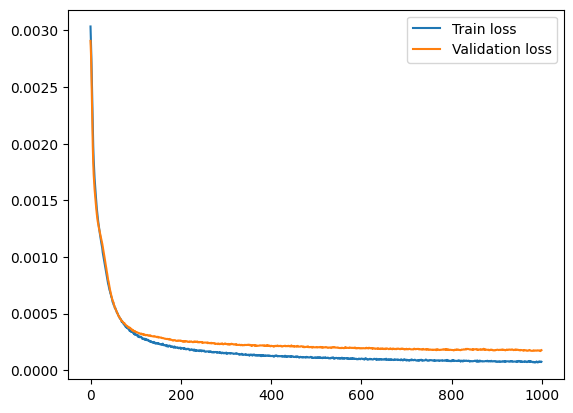

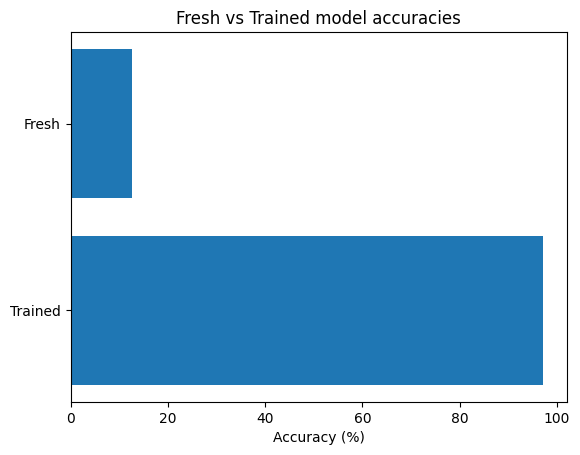

accuracy_trained,▁
train_loss,█▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▅▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy_trained,97.10001
train_loss,8e-05
valid_loss,0.00018


In [8]:
config_name = "classifier_30.yaml"
config = cfg.load_config(config_name)
print("Config loaded:\n", config)

default_dirs = cfg.get_default_dirs()
models_dir = Path(default_dirs["models_dir"])
datasets_dir = Path(default_dirs["datasets_dir"])

name = ''.join(random.choices(string.ascii_lowercase, k=7))
name = config["name"]
# Hyperparameters
hyperparameters = config["hyperparameters"]
epochs = hyperparameters["epochs"]
learning_rate = hyperparameters["learning_rate"]
seed = hyperparameters["seed"]

# Model config
model_config = config["model"]
input_dim = model_config["input_dim"]
hidden_dims = model_config["hidden_dims"]
output_dim = model_config["output_dim"]
dropout = model_config.get("dropout", 0.0)
use_batch_norm = model_config.get("use_batch_norm", False)
output_activation = model_config.get("output_activation", "softmax")

# Load dataset
dataset_config = config["dataset"]
dataset_name = dataset_config["name"]
dataset_splits = dataset_config["splits"]
batch_size = dataset_config["batch_size"]
dataset_seed = dataset_config["seed"]

dataset_path = datasets_dir / dataset_name
print(dataset_path)
# Create a dataset
dataset = ModelParamsDataset(dataset_path, 45)

torch.manual_seed(dataset_seed)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Split into train, validation and test sets
dataset_train, dataset_valid, dataset_test = torch.utils.data.random_split(dataset, dataset_splits)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataloader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=True)
dataloader_test = torch.utils.data.DataLoader(dataset_test)

print("Train sample:", len(dataset_train))
print("Validation sample:", len(dataset_valid))
print("Test sample:", len(dataset_test))


torch.manual_seed(seed)
wandb_config = dotenv_values("../.env")
wandb.init(project=wandb_config["WANDB_PROJECT"], entity=wandb_config["WANDB_ENTITY"], config=config, group="weight_classifier")

# Init
model = MLP(input_dim, hidden_dims, output_dim, dropout, use_batch_norm, output_activation)
model.to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_losses, valid_losses = trainer.train_mlp(model, epochs, learning_rate, criterion, optimizer, dataloader_train, dataloader_valid)

plt.plot(train_losses, label="Train loss")
plt.plot(valid_losses, label="Validation loss")
plt.legend()
plt.show()

# Check improvement compared to a fresh model
model_fresh = MLP(input_dim, hidden_dims, output_dim, dropout, use_batch_norm, output_activation)
accuracy_fresh = trainer.get_accuracy(model_fresh, dataloader_test)
accuracy_trained = trainer.get_accuracy(model, dataloader_test)

wandb.log({"accuracy_trained": accuracy_trained})

plt.title("Fresh vs Trained model accuracies")
plt.barh(["Trained", "Fresh"], [accuracy_trained, accuracy_fresh])
plt.xlabel("Accuracy (%)")
plt.show()

torch.save(model.state_dict(), models_dir / f"{name}.pth")
wandb.alert(title="Model trai`ning finished", text=f"Model [{config_name}] training finished successfully.\n Accuracy: {accuracy_trained}")
wandb.finish()

Config loaded:
 {'name': 'classifier_31', 'dataset': {'name': 'eight_angles.csv', 'splits': [0.7, 0.2, 0.1], 'batch_size': 128, 'seed': 42}, 'hyperparameters': {'epochs': 1000, 'learning_rate': 0.001, 'optimizer': 'sgd', 'criterion': 'bce', 'seed': 42}, 'model': {'input_dim': 151, 'hidden_dims': [400, 200], 'output_dim': 8, 'use_batch_norm': True, 'dropout': 0.2, 'output_activation': 'softmax'}}
C:\Projects\Python\master-thesis\data\eight_angles.csv


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Train sample: 56000
Validation sample: 16000
Test sample: 8000


wandb: Currently logged in as: idavron (idavron-team). Use `wandb login --relogin` to force relogin


100%|██████████| 1000/1000 [3:48:49<00:00, 13.73s/it] 


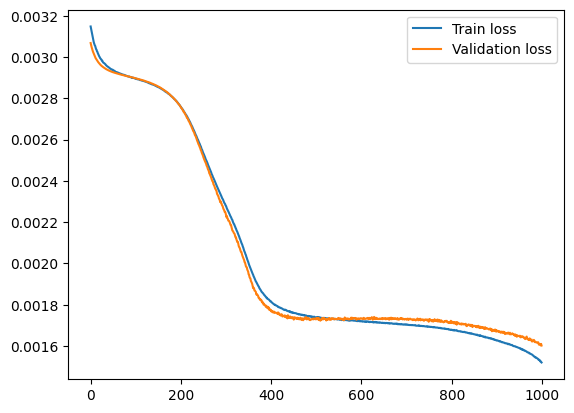

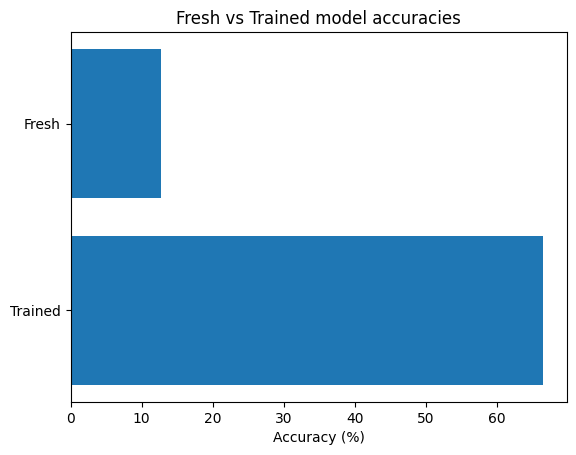

accuracy_trained,▁
train_loss,██▇▇▇▇▇▇▆▆▅▅▄▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
valid_loss,███▇▇▇▇▇▇▆▅▅▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
accuracy_trained,66.4875
train_loss,0.00152
valid_loss,0.0016


In [ ]:
config_name = "classifier_31.yaml"
config = cfg.load_config(config_name)
print("Config loaded:\n", config)

default_dirs = cfg.get_default_dirs()
models_dir = Path(default_dirs["models_dir"])
datasets_dir = Path(default_dirs["datasets_dir"])

name = ''.join(random.choices(string.ascii_lowercase, k=7))
name = config["name"]
# Hyperparameters
hyperparameters = config["hyperparameters"]
epochs = hyperparameters["epochs"]
learning_rate = hyperparameters["learning_rate"]
seed = hyperparameters["seed"]

# Model config
model_config = config["model"]
input_dim = model_config["input_dim"]
hidden_dims = model_config["hidden_dims"]
output_dim = model_config["output_dim"]
dropout = model_config.get("dropout", 0.0)
use_batch_norm = model_config.get("use_batch_norm", False)
output_activation = model_config.get("output_activation", "softmax")

# Load dataset
dataset_config = config["dataset"]
dataset_name = dataset_config["name"]
dataset_splits = dataset_config["splits"]
batch_size = dataset_config["batch_size"]
dataset_seed = dataset_config["seed"]

dataset_path = datasets_dir / dataset_name
print(dataset_path)
# Create a dataset
dataset = ModelParamsDataset(dataset_path, 45)

torch.manual_seed(dataset_seed)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Split into train, validation and test sets
dataset_train, dataset_valid, dataset_test = torch.utils.data.random_split(dataset, dataset_splits)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataloader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=True)
dataloader_test = torch.utils.data.DataLoader(dataset_test)

print("Train sample:", len(dataset_train))
print("Validation sample:", len(dataset_valid))
print("Test sample:", len(dataset_test))


torch.manual_seed(seed)
wandb_config = dotenv_values("../.env")
wandb.init(project=wandb_config["WANDB_PROJECT"], entity=wandb_config["WANDB_ENTITY"], config=config, group="weight_classifier")

# Init
model = MLP(input_dim, hidden_dims, output_dim, dropout, use_batch_norm, output_activation)
model.to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=0.01)

train_losses, valid_losses = trainer.train_mlp(model, epochs, learning_rate, criterion, optimizer, dataloader_train, dataloader_valid)

plt.plot(train_losses, label="Train loss")
plt.plot(valid_losses, label="Validation loss")
plt.legend()
plt.show()

# Check improvement compared to a fresh model
model_fresh = MLP(input_dim, hidden_dims, output_dim, dropout, use_batch_norm, output_activation)
accuracy_fresh = trainer.get_accuracy(model_fresh, dataloader_test)
accuracy_trained = trainer.get_accuracy(model, dataloader_test)

wandb.log({"accuracy_trained": accuracy_trained})

plt.title("Fresh vs Trained model accuracies")
plt.barh(["Trained", "Fresh"], [accuracy_trained, accuracy_fresh])
plt.xlabel("Accuracy (%)")
plt.show()

torch.save(model.state_dict(), models_dir / f"{name}.pth")
wandb.alert(title="Model trai`ning finished", text=f"Model [{config_name}] training finished successfully.\n Accuracy: {accuracy_trained}")
wandb.finish()

Config loaded:
 {'name': 'classifier_32', 'dataset': {'name': 'eight_angles.csv', 'splits': [0.7, 0.2, 0.1], 'batch_size': 128, 'seed': 42}, 'hyperparameters': {'epochs': 1000, 'learning_rate': 0.005, 'optimizer': 'sgd', 'criterion': 'bce', 'seed': 42}, 'model': {'input_dim': 151, 'hidden_dims': [400, 200], 'output_dim': 8, 'use_batch_norm': True, 'dropout': 0.2, 'output_activation': 'softmax'}}
C:\Projects\Python\master-thesis\data\eight_angles.csv


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Train sample: 56000
Validation sample: 16000
Test sample: 8000


wandb: Currently logged in as: idavron (idavron-team). Use `wandb login --relogin` to force relogin


100%|██████████| 1000/1000 [5:18:29<00:00, 19.11s/it] 


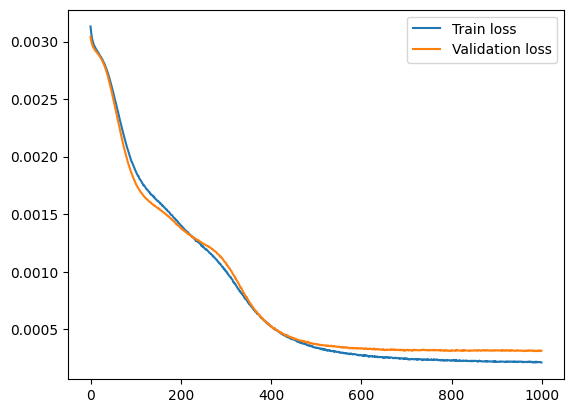

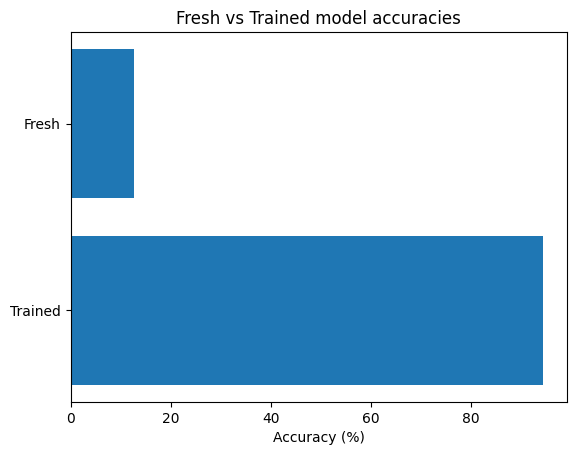

accuracy_trained,▁
train_loss,██▇▆▅▅▄▄▄▄▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,██▇▆▅▄▄▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy_trained,94.31251
train_loss,0.00021
valid_loss,0.00031


In [7]:
config_name = "classifier_32.yaml"
config = cfg.load_config(config_name)
print("Config loaded:\n", config)

default_dirs = cfg.get_default_dirs()
models_dir = Path(default_dirs["models_dir"])
datasets_dir = Path(default_dirs["datasets_dir"])

name = ''.join(random.choices(string.ascii_lowercase, k=7))
name = config["name"]
# Hyperparameters
hyperparameters = config["hyperparameters"]
epochs = hyperparameters["epochs"]
learning_rate = hyperparameters["learning_rate"]
seed = hyperparameters["seed"]

# Model config
model_config = config["model"]
input_dim = model_config["input_dim"]
hidden_dims = model_config["hidden_dims"]
output_dim = model_config["output_dim"]
dropout = model_config.get("dropout", 0.0)
use_batch_norm = model_config.get("use_batch_norm", False)
output_activation = model_config.get("output_activation", "softmax")

# Load dataset
dataset_config = config["dataset"]
dataset_name = dataset_config["name"]
dataset_splits = dataset_config["splits"]
batch_size = dataset_config["batch_size"]
dataset_seed = dataset_config["seed"]

dataset_path = datasets_dir / dataset_name
print(dataset_path)
# Create a dataset
dataset = ModelParamsDataset(dataset_path, 45)

torch.manual_seed(dataset_seed)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Split into train, validation and test sets
dataset_train, dataset_valid, dataset_test = torch.utils.data.random_split(dataset, dataset_splits)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataloader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=True)
dataloader_test = torch.utils.data.DataLoader(dataset_test)

print("Train sample:", len(dataset_train))
print("Validation sample:", len(dataset_valid))
print("Test sample:", len(dataset_test))


torch.manual_seed(seed)
wandb_config = dotenv_values("../.env")
wandb.init(project=wandb_config["WANDB_PROJECT"], entity=wandb_config["WANDB_ENTITY"], config=config, group="weight_classifier")

# Init
model = MLP(input_dim, hidden_dims, output_dim, dropout, use_batch_norm, output_activation)
model.to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=0.001)

train_losses, valid_losses = trainer.train_mlp(model, epochs, learning_rate, criterion, optimizer, dataloader_train, dataloader_valid)

plt.plot(train_losses, label="Train loss")
plt.plot(valid_losses, label="Validation loss")
plt.legend()
plt.show()

# Check improvement compared to a fresh model
model_fresh = MLP(input_dim, hidden_dims, output_dim, dropout, use_batch_norm, output_activation)
accuracy_fresh = trainer.get_accuracy(model_fresh, dataloader_test)
accuracy_trained = trainer.get_accuracy(model, dataloader_test)

wandb.log({"accuracy_trained": accuracy_trained})

plt.title("Fresh vs Trained model accuracies")
plt.barh(["Trained", "Fresh"], [accuracy_trained, accuracy_fresh])
plt.xlabel("Accuracy (%)")
plt.show()

torch.save(model.state_dict(), models_dir / f"{name}.pth")
wandb.alert(title="Model trai`ning finished", text=f"Model [{config_name}] training finished successfully.\n Accuracy: {accuracy_trained}")
wandb.finish()

Config loaded:
 {'name': 'classifier_33', 'dataset': {'name': 'eight_angles.csv', 'splits': [0.7, 0.2, 0.1], 'batch_size': 128, 'seed': 42}, 'hyperparameters': {'epochs': 2000, 'learning_rate': 0.0001, 'optimizer': 'adam', 'criterion': 'bce', 'seed': 42}, 'model': {'input_dim': 151, 'hidden_dims': [400, 200], 'output_dim': 8, 'use_batch_norm': True, 'dropout': 0.2, 'output_activation': 'softmax'}}
C:\Projects\Python\master-thesis\data\eight_angles.csv
Train sample: 56000
Validation sample: 16000
Test sample: 8000


100%|██████████| 2000/2000 [7:20:57<00:00, 13.23s/it]  


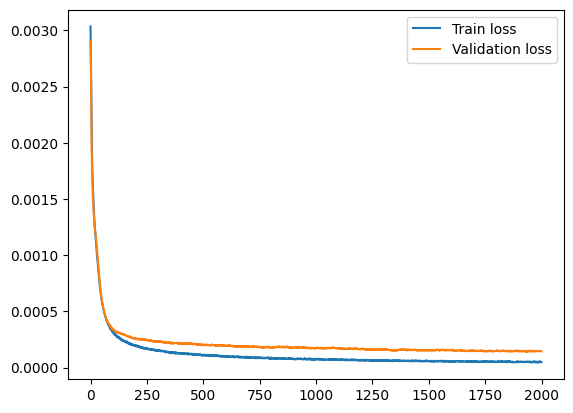

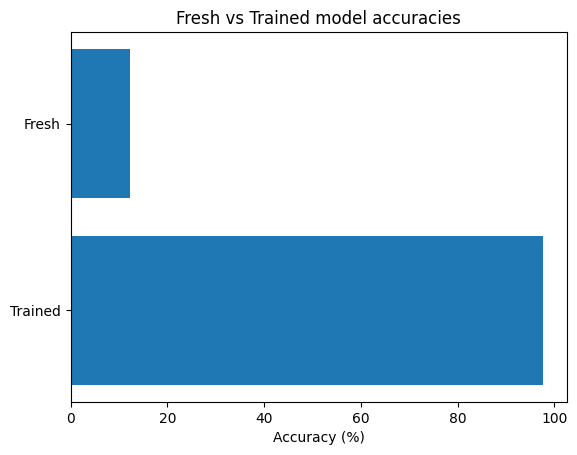

accuracy_trained,▁
train_loss,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy_trained,97.66251
train_loss,5e-05
valid_loss,0.00014


In [8]:
config_name = "classifier_33.yaml"
config = cfg.load_config(config_name)
print("Config loaded:\n", config)

default_dirs = cfg.get_default_dirs()
models_dir = Path(default_dirs["models_dir"])
datasets_dir = Path(default_dirs["datasets_dir"])

name = ''.join(random.choices(string.ascii_lowercase, k=7))
name = config["name"]
# Hyperparameters
hyperparameters = config["hyperparameters"]
epochs = hyperparameters["epochs"]
learning_rate = hyperparameters["learning_rate"]
seed = hyperparameters["seed"]

# Model config
model_config = config["model"]
input_dim = model_config["input_dim"]
hidden_dims = model_config["hidden_dims"]
output_dim = model_config["output_dim"]
dropout = model_config.get("dropout", 0.0)
use_batch_norm = model_config.get("use_batch_norm", False)
output_activation = model_config.get("output_activation", "softmax")

# Load dataset
dataset_config = config["dataset"]
dataset_name = dataset_config["name"]
dataset_splits = dataset_config["splits"]
batch_size = dataset_config["batch_size"]
dataset_seed = dataset_config["seed"]

dataset_path = datasets_dir / dataset_name
print(dataset_path)
# Create a dataset
dataset = ModelParamsDataset(dataset_path, 45)

torch.manual_seed(dataset_seed)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Split into train, validation and test sets
dataset_train, dataset_valid, dataset_test = torch.utils.data.random_split(dataset, dataset_splits)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataloader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=True)
dataloader_test = torch.utils.data.DataLoader(dataset_test)

print("Train sample:", len(dataset_train))
print("Validation sample:", len(dataset_valid))
print("Test sample:", len(dataset_test))


torch.manual_seed(seed)
wandb_config = dotenv_values("../.env")
wandb.init(project=wandb_config["WANDB_PROJECT"], entity=wandb_config["WANDB_ENTITY"], config=config, group="weight_classifier")

# Init
model = MLP(input_dim, hidden_dims, output_dim, dropout, use_batch_norm, output_activation)
model.to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_losses, valid_losses = trainer.train_mlp(model, epochs, learning_rate, criterion, optimizer, dataloader_train, dataloader_valid)

plt.plot(train_losses, label="Train loss")
plt.plot(valid_losses, label="Validation loss")
plt.legend()
plt.show()

# Check improvement compared to a fresh model
model_fresh = MLP(input_dim, hidden_dims, output_dim, dropout, use_batch_norm, output_activation)
accuracy_fresh = trainer.get_accuracy(model_fresh, dataloader_test)
accuracy_trained = trainer.get_accuracy(model, dataloader_test)

wandb.log({"accuracy_trained": accuracy_trained})

plt.title("Fresh vs Trained model accuracies")
plt.barh(["Trained", "Fresh"], [accuracy_trained, accuracy_fresh])
plt.xlabel("Accuracy (%)")
plt.show()

torch.save(model.state_dict(), models_dir / f"{name}.pth")
wandb.alert(title="Model trai`ning finished", text=f"Model [{config_name}] training finished successfully.\n Accuracy: {accuracy_trained}")
wandb.finish()

Config loaded:
 {'name': 'classifier_34', 'dataset': {'name': 'eight_angles_pruned.csv', 'splits': [0.7, 0.2, 0.1], 'batch_size': 128, 'seed': 42}, 'hyperparameters': {'epochs': 50, 'learning_rate': 0.005, 'optimizer': 'adam', 'criterion': 'bce', 'seed': 42}, 'model': {'input_dim': 151, 'hidden_dims': [400, 200], 'output_dim': 8, 'use_batch_norm': True, 'dropout': 0.2, 'output_activation': 'softmax'}}
C:\Projects\Python\master-thesis\data\eight_angles_pruned.csv


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Train sample: 56000
Validation sample: 16000
Test sample: 8000


wandb: Currently logged in as: idavron (idavron-team). Use `wandb login --relogin` to force relogin


100%|██████████| 50/50 [12:02<00:00, 14.45s/it]


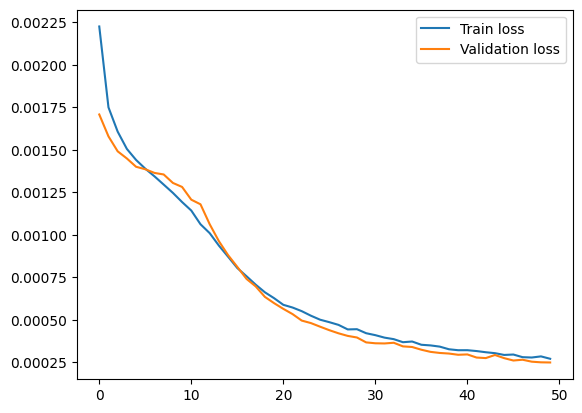

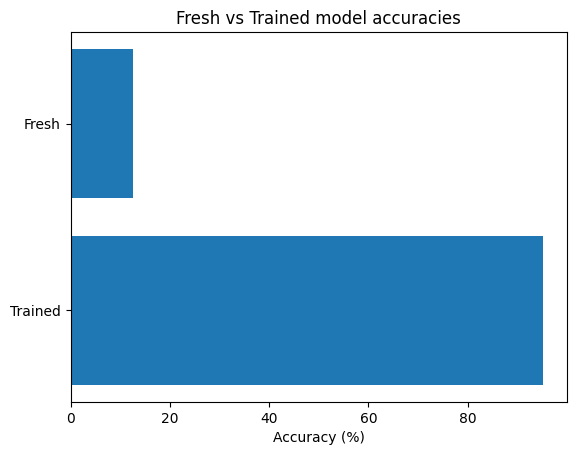

accuracy_trained,▁
train_loss,█▆▆▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▇▇▇▆▆▆▆▆▅▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy_trained,95.175
train_loss,0.00027
valid_loss,0.00025


In [3]:
config_name = "classifier_34.yaml"
config = cfg.load_config(config_name)
print("Config loaded:\n", config)

default_dirs = cfg.get_default_dirs()
models_dir = Path(default_dirs["models_dir"])
datasets_dir = Path(default_dirs["datasets_dir"])

name = ''.join(random.choices(string.ascii_lowercase, k=7))
name = config["name"]
# Hyperparameters
hyperparameters = config["hyperparameters"]
epochs = hyperparameters["epochs"]
learning_rate = hyperparameters["learning_rate"]
seed = hyperparameters["seed"]

# Model config
model_config = config["model"]
input_dim = model_config["input_dim"]
hidden_dims = model_config["hidden_dims"]
output_dim = model_config["output_dim"]
dropout = model_config.get("dropout", 0.0)
use_batch_norm = model_config.get("use_batch_norm", False)
output_activation = model_config.get("output_activation", "softmax")

# Load dataset
dataset_config = config["dataset"]
dataset_name = dataset_config["name"]
dataset_splits = dataset_config["splits"]
batch_size = dataset_config["batch_size"]
dataset_seed = dataset_config["seed"]

dataset_path = datasets_dir / dataset_name
print(dataset_path)
# Create a dataset
dataset = ModelParamsDataset(dataset_path, 45)

torch.manual_seed(dataset_seed)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Split into train, validation and test sets
dataset_train, dataset_valid, dataset_test = torch.utils.data.random_split(dataset, dataset_splits)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataloader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=True)
dataloader_test = torch.utils.data.DataLoader(dataset_test)

print("Train sample:", len(dataset_train))
print("Validation sample:", len(dataset_valid))
print("Test sample:", len(dataset_test))


torch.manual_seed(seed)
wandb_config = dotenv_values("../.env")
wandb.init(project=wandb_config["WANDB_PROJECT"], entity=wandb_config["WANDB_ENTITY"], config=config, group="weight_classifier")

# Init
model = MLP(input_dim, hidden_dims, output_dim, dropout, use_batch_norm, output_activation)
model.to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_losses, valid_losses = trainer.train_mlp(model, epochs, learning_rate, criterion, optimizer, dataloader_train, dataloader_valid)

plt.plot(train_losses, label="Train loss")
plt.plot(valid_losses, label="Validation loss")
plt.legend()
plt.show()

# Check improvement compared to a fresh model
model_fresh = MLP(input_dim, hidden_dims, output_dim, dropout, use_batch_norm, output_activation)
accuracy_fresh = trainer.get_accuracy(model_fresh, dataloader_test)
accuracy_trained = trainer.get_accuracy(model, dataloader_test)

wandb.log({"accuracy_trained": accuracy_trained})

plt.title("Fresh vs Trained model accuracies")
plt.barh(["Trained", "Fresh"], [accuracy_trained, accuracy_fresh])
plt.xlabel("Accuracy (%)")
plt.show()

torch.save(model.state_dict(), models_dir / f"{name}.pth")
wandb.alert(title="Model trai`ning finished", text=f"Model [{config_name}] training finished successfully.\n Accuracy: {accuracy_trained}")
wandb.finish()

Config loaded:
 {'name': 'classifier_35', 'dataset': {'name': 'eight_angles_pruned.csv', 'splits': [0.7, 0.2, 0.1], 'batch_size': 128, 'seed': 42}, 'hyperparameters': {'epochs': 1000, 'learning_rate': 0.005, 'optimizer': 'adam', 'criterion': 'bce', 'seed': 42}, 'model': {'input_dim': 151, 'hidden_dims': [400, 200], 'output_dim': 8, 'use_batch_norm': True, 'dropout': 0.2, 'output_activation': 'softmax'}}
C:\Projects\Python\master-thesis\data\eight_angles_pruned.csv
Train sample: 56000
Validation sample: 16000
Test sample: 8000


100%|██████████| 1000/1000 [3:53:21<00:00, 14.00s/it] 


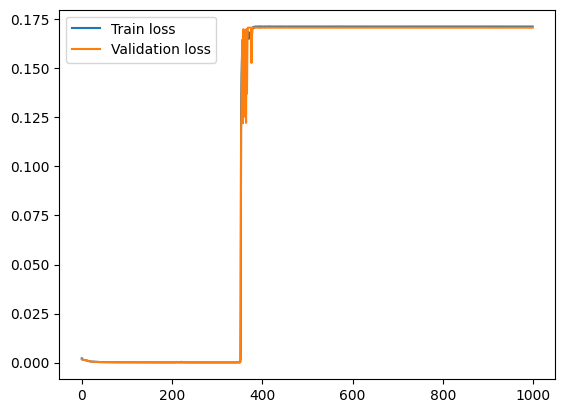

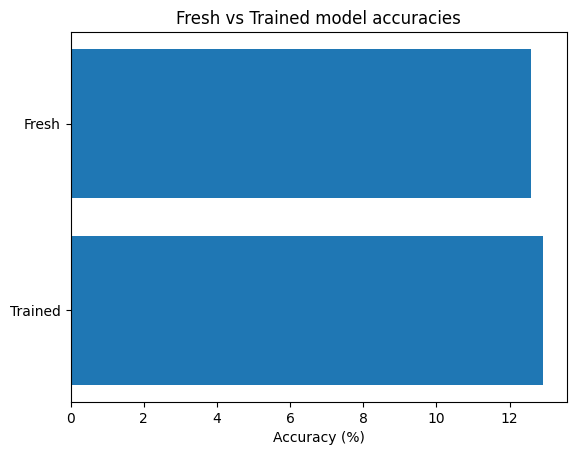

accuracy_trained,▁
train_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▇█████████████████████████
valid_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁██████████████████████████
accuracy_trained,12.9125
train_loss,0.17126
valid_loss,0.17068


In [5]:
config_name = "classifier_35.yaml"
config = cfg.load_config(config_name)
print("Config loaded:\n", config)

default_dirs = cfg.get_default_dirs()
models_dir = Path(default_dirs["models_dir"])
datasets_dir = Path(default_dirs["datasets_dir"])

name = ''.join(random.choices(string.ascii_lowercase, k=7))
name = config["name"]
# Hyperparameters
hyperparameters = config["hyperparameters"]
epochs = hyperparameters["epochs"]
learning_rate = hyperparameters["learning_rate"]
seed = hyperparameters["seed"]

# Model config
model_config = config["model"]
input_dim = model_config["input_dim"]
hidden_dims = model_config["hidden_dims"]
output_dim = model_config["output_dim"]
dropout = model_config.get("dropout", 0.0)
use_batch_norm = model_config.get("use_batch_norm", False)
output_activation = model_config.get("output_activation", "softmax")

# Load dataset
dataset_config = config["dataset"]
dataset_name = dataset_config["name"]
dataset_splits = dataset_config["splits"]
batch_size = dataset_config["batch_size"]
dataset_seed = dataset_config["seed"]

dataset_path = datasets_dir / dataset_name
print(dataset_path)
# Create a dataset
dataset = ModelParamsDataset(dataset_path, 45)

torch.manual_seed(dataset_seed)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Split into train, validation and test sets
dataset_train, dataset_valid, dataset_test = torch.utils.data.random_split(dataset, dataset_splits)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataloader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=True)
dataloader_test = torch.utils.data.DataLoader(dataset_test)

print("Train sample:", len(dataset_train))
print("Validation sample:", len(dataset_valid))
print("Test sample:", len(dataset_test))


torch.manual_seed(seed)
wandb_config = dotenv_values("../.env")
wandb.init(project=wandb_config["WANDB_PROJECT"], entity=wandb_config["WANDB_ENTITY"], config=config, group="weight_classifier")

# Init
model = MLP(input_dim, hidden_dims, output_dim, dropout, use_batch_norm, output_activation)
model.to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_losses, valid_losses = trainer.train_mlp(model, epochs, learning_rate, criterion, optimizer, dataloader_train, dataloader_valid)

plt.plot(train_losses, label="Train loss")
plt.plot(valid_losses, label="Validation loss")
plt.legend()
plt.show()

# Check improvement compared to a fresh model
model_fresh = MLP(input_dim, hidden_dims, output_dim, dropout, use_batch_norm, output_activation)
accuracy_fresh = trainer.get_accuracy(model_fresh, dataloader_test)
accuracy_trained = trainer.get_accuracy(model, dataloader_test)

wandb.log({"accuracy_trained": accuracy_trained})

plt.title("Fresh vs Trained model accuracies")
plt.barh(["Trained", "Fresh"], [accuracy_trained, accuracy_fresh])
plt.xlabel("Accuracy (%)")
plt.show()

torch.save(model.state_dict(), models_dir / f"{name}.pth")
wandb.alert(title="Model trai`ning finished", text=f"Model [{config_name}] training finished successfully.\n Accuracy: {accuracy_trained}")
wandb.finish()

Config loaded:
 {'name': 'classifier_36', 'dataset': {'name': 'eight_angles_pruned.csv', 'splits': [0.7, 0.2, 0.1], 'batch_size': 128, 'seed': 42}, 'hyperparameters': {'epochs': 1000, 'learning_rate': 0.001, 'optimizer': 'adam', 'criterion': 'bce', 'seed': 42}, 'model': {'input_dim': 151, 'hidden_dims': [400, 200], 'output_dim': 8, 'use_batch_norm': True, 'dropout': 0.2, 'output_activation': 'softmax'}}
C:\Projects\Python\master-thesis\data\eight_angles_pruned.csv


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Train sample: 56000
Validation sample: 16000
Test sample: 8000


wandb: Currently logged in as: idavron (idavron-team). Use `wandb login --relogin` to force relogin


100%|██████████| 1000/1000 [3:45:50<00:00, 13.55s/it] 


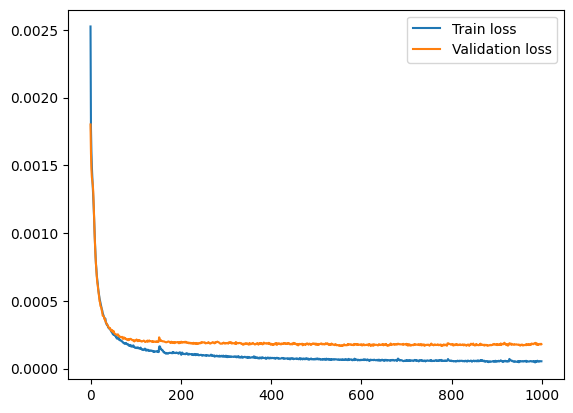

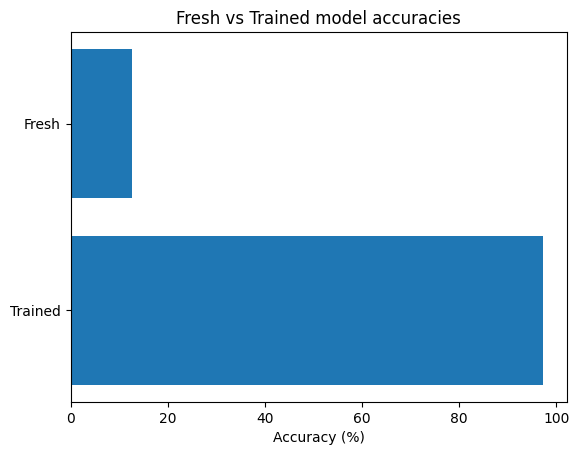

accuracy_trained,▁
train_loss,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy_trained,97.28751
train_loss,5e-05
valid_loss,0.00018


In [4]:
config_name = "classifier_36.yaml"
config = cfg.load_config(config_name)
print("Config loaded:\n", config)

default_dirs = cfg.get_default_dirs()
models_dir = Path(default_dirs["models_dir"])
datasets_dir = Path(default_dirs["datasets_dir"])

name = ''.join(random.choices(string.ascii_lowercase, k=7))
name = config["name"]
# Hyperparameters
hyperparameters = config["hyperparameters"]
epochs = hyperparameters["epochs"]
learning_rate = hyperparameters["learning_rate"]
seed = hyperparameters["seed"]

# Model config
model_config = config["model"]
input_dim = model_config["input_dim"]
hidden_dims = model_config["hidden_dims"]
output_dim = model_config["output_dim"]
dropout = model_config.get("dropout", 0.0)
use_batch_norm = model_config.get("use_batch_norm", False)
output_activation = model_config.get("output_activation", "softmax")

# Load dataset
dataset_config = config["dataset"]
dataset_name = dataset_config["name"]
dataset_splits = dataset_config["splits"]
batch_size = dataset_config["batch_size"]
dataset_seed = dataset_config["seed"]

dataset_path = datasets_dir / dataset_name
print(dataset_path)
# Create a dataset
dataset = ModelParamsDataset(dataset_path, 45)

torch.manual_seed(dataset_seed)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Split into train, validation and test sets
dataset_train, dataset_valid, dataset_test = torch.utils.data.random_split(dataset, dataset_splits)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataloader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=True)
dataloader_test = torch.utils.data.DataLoader(dataset_test)

print("Train sample:", len(dataset_train))
print("Validation sample:", len(dataset_valid))
print("Test sample:", len(dataset_test))


torch.manual_seed(seed)
wandb_config = dotenv_values("../.env")
wandb.init(project=wandb_config["WANDB_PROJECT"], entity=wandb_config["WANDB_ENTITY"], config=config, group="weight_classifier")

# Init
model = MLP(input_dim, hidden_dims, output_dim, dropout, use_batch_norm, output_activation)
model.to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_losses, valid_losses = trainer.train_mlp(model, epochs, learning_rate, criterion, optimizer, dataloader_train, dataloader_valid)

plt.plot(train_losses, label="Train loss")
plt.plot(valid_losses, label="Validation loss")
plt.legend()
plt.show()

# Check improvement compared to a fresh model
model_fresh = MLP(input_dim, hidden_dims, output_dim, dropout, use_batch_norm, output_activation)
accuracy_fresh = trainer.get_accuracy(model_fresh, dataloader_test)
accuracy_trained = trainer.get_accuracy(model, dataloader_test)

wandb.log({"accuracy_trained": accuracy_trained})

plt.title("Fresh vs Trained model accuracies")
plt.barh(["Trained", "Fresh"], [accuracy_trained, accuracy_fresh])
plt.xlabel("Accuracy (%)")
plt.show()

torch.save(model.state_dict(), models_dir / f"{name}.pth")
wandb.alert(title="Model trai`ning finished", text=f"Model [{config_name}] training finished successfully.\n Accuracy: {accuracy_trained}")
wandb.finish()

Config loaded:
 {'name': 'classifier_37', 'dataset': {'name': 'eight_angles_pruned.csv', 'splits': [0.7, 0.2, 0.1], 'batch_size': 128, 'seed': 42}, 'hyperparameters': {'epochs': 1000, 'learning_rate': 0.001, 'weight_decay': 0.01, 'optimizer': 'sgd', 'criterion': 'bce', 'seed': 42}, 'model': {'input_dim': 151, 'hidden_dims': [400, 200], 'output_dim': 8, 'use_batch_norm': True, 'dropout': 0.2, 'output_activation': 'softmax'}}
C:\Projects\Python\master-thesis\data\eight_angles_pruned.csv
Train sample: 56000
Validation sample: 16000
Test sample: 8000


100%|██████████| 1000/1000 [3:18:57<00:00, 11.94s/it] 


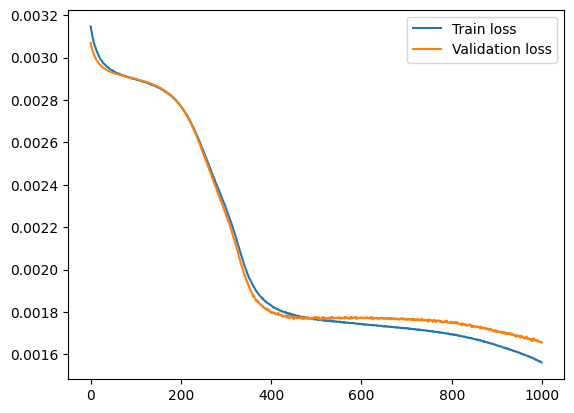

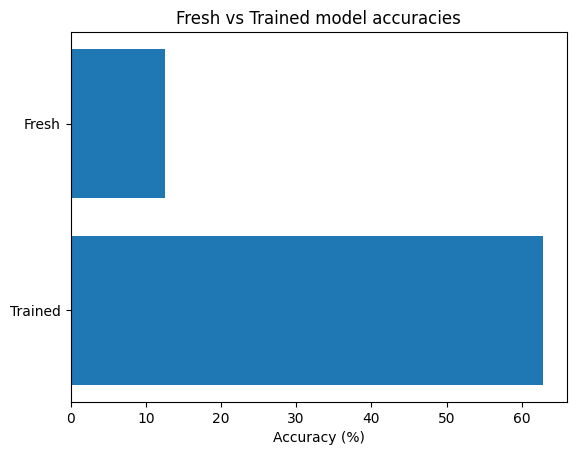

accuracy_trained,▁
train_loss,██▇▇▇▇▇▇▆▆▅▅▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
valid_loss,███▇▇▇▇▇▇▆▅▅▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
accuracy_trained,62.825
train_loss,0.00156
valid_loss,0.00166


In [5]:
config_name = "classifier_37.yaml"
config = cfg.load_config(config_name)
print("Config loaded:\n", config)

default_dirs = cfg.get_default_dirs()
models_dir = Path(default_dirs["models_dir"])
datasets_dir = Path(default_dirs["datasets_dir"])

name = ''.join(random.choices(string.ascii_lowercase, k=7))
name = config["name"]
# Hyperparameters
hyperparameters = config["hyperparameters"]
epochs = hyperparameters["epochs"]
learning_rate = hyperparameters["learning_rate"]
weight_decay = hyperparameters["weight_decay"]
seed = hyperparameters["seed"]

# Model config
model_config = config["model"]
input_dim = model_config["input_dim"]
hidden_dims = model_config["hidden_dims"]
output_dim = model_config["output_dim"]
dropout = model_config.get("dropout", 0.0)
use_batch_norm = model_config.get("use_batch_norm", False)
output_activation = model_config.get("output_activation", "softmax")

# Load dataset
dataset_config = config["dataset"]
dataset_name = dataset_config["name"]
dataset_splits = dataset_config["splits"]
batch_size = dataset_config["batch_size"]
dataset_seed = dataset_config["seed"]

dataset_path = datasets_dir / dataset_name
print(dataset_path)
# Create a dataset
dataset = ModelParamsDataset(dataset_path, 45)

torch.manual_seed(dataset_seed)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Split into train, validation and test sets
dataset_train, dataset_valid, dataset_test = torch.utils.data.random_split(dataset, dataset_splits)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataloader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=True)
dataloader_test = torch.utils.data.DataLoader(dataset_test)

print("Train sample:", len(dataset_train))
print("Validation sample:", len(dataset_valid))
print("Test sample:", len(dataset_test))


torch.manual_seed(seed)
wandb_config = dotenv_values("../.env")
wandb.init(project=wandb_config["WANDB_PROJECT"], entity=wandb_config["WANDB_ENTITY"], config=config, group="weight_classifier")

# Init
model = MLP(input_dim, hidden_dims, output_dim, dropout, use_batch_norm, output_activation)
model.to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

train_losses, valid_losses = trainer.train_mlp(model, epochs, learning_rate, criterion, optimizer, dataloader_train, dataloader_valid)

plt.plot(train_losses, label="Train loss")
plt.plot(valid_losses, label="Validation loss")
plt.legend()
plt.show()

# Check improvement compared to a fresh model
model_fresh = MLP(input_dim, hidden_dims, output_dim, dropout, use_batch_norm, output_activation)
accuracy_fresh = trainer.get_accuracy(model_fresh, dataloader_test)
accuracy_trained = trainer.get_accuracy(model, dataloader_test)

wandb.log({"accuracy_trained": accuracy_trained})

plt.title("Fresh vs Trained model accuracies")
plt.barh(["Trained", "Fresh"], [accuracy_trained, accuracy_fresh])
plt.xlabel("Accuracy (%)")
plt.show()

torch.save(model.state_dict(), models_dir / f"{name}.pth")
wandb.alert(title="Model trai`ning finished", text=f"Model [{config_name}] training finished successfully.\n Accuracy: {accuracy_trained}")
wandb.finish()

Config loaded:
 {'name': 'classifier', 'dataset': {'name': 'eight_angles.csv', 'splits': [0.7, 0.2, 0.1], 'batch_size': 128, 'seed': 42}, 'hyperparameters': {'epochs': 50, 'learning_rate': 0.005, 'optimizer': 'adam', 'criterion': 'bce', 'seed': 42}, 'model': {'input_dim': 151, 'hidden_dims': [400, 200], 'output_dim': 8, 'use_batch_norm': True, 'dropout': 0.2, 'output_activation': 'softmax'}}
C:\Projects\Python\master-thesis\data\eight_angles.csv


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Train sample: 56000
Validation sample: 16000
Test sample: 8000


wandb: Currently logged in as: idavron (idavron-team). Use `wandb login --relogin` to force relogin


100%|██████████| 50/50 [10:34<00:00, 12.68s/it]


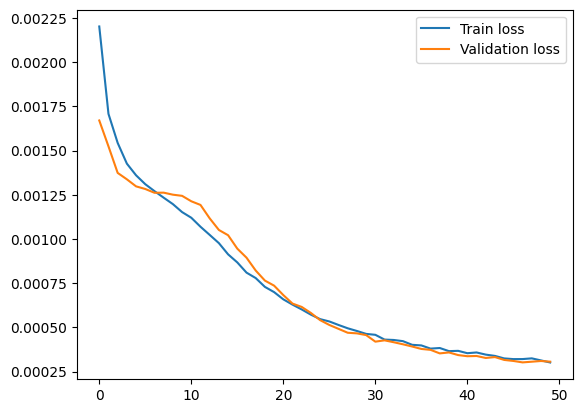

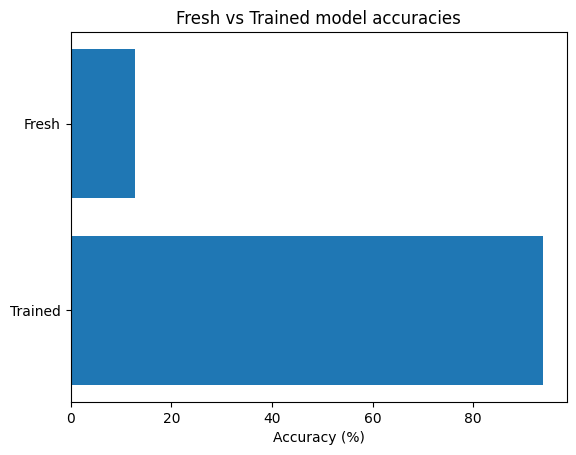

accuracy_trained,▁
train_loss,█▆▆▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▇▆▆▆▆▆▆▆▆▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
accuracy_trained,93.85001
train_loss,0.0003
valid_loss,0.00031


In [3]:
config_name = "classifier_default.yaml"
config = cfg.load_config(config_name)
print("Config loaded:\n", config)

default_dirs = cfg.get_default_dirs()
models_dir = Path(default_dirs["models_dir"])
datasets_dir = Path(default_dirs["datasets_dir"])

name = ''.join(random.choices(string.ascii_lowercase, k=7))
name = config["name"]
# Hyperparameters
hyperparameters = config["hyperparameters"]
epochs = hyperparameters["epochs"]
learning_rate = hyperparameters["learning_rate"]
seed = hyperparameters["seed"]

# Model config
model_config = config["model"]
input_dim = model_config["input_dim"]
hidden_dims = model_config["hidden_dims"]
output_dim = model_config["output_dim"]
dropout = model_config.get("dropout", 0.0)
use_batch_norm = model_config.get("use_batch_norm", False)
output_activation = model_config.get("output_activation", "softmax")

# Load dataset
dataset_config = config["dataset"]
dataset_name = dataset_config["name"]
dataset_splits = dataset_config["splits"]
batch_size = dataset_config["batch_size"]
dataset_seed = dataset_config["seed"]

dataset_path = datasets_dir / dataset_name
print(dataset_path)
# Create a dataset
dataset = ModelParamsDataset(dataset_path, 45)

torch.manual_seed(dataset_seed)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Split into train, validation and test sets
dataset_train, dataset_valid, dataset_test = torch.utils.data.random_split(dataset, dataset_splits)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataloader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=True)
dataloader_test = torch.utils.data.DataLoader(dataset_test)

print("Train sample:", len(dataset_train))
print("Validation sample:", len(dataset_valid))
print("Test sample:", len(dataset_test))


torch.manual_seed(seed)
wandb_config = dotenv_values("../.env")
run = wandb.init(project=wandb_config["WANDB_PROJECT"], entity=wandb_config["WANDB_ENTITY"], config=config, group="weight_classifier")

# Init
model = MLP(input_dim, hidden_dims, output_dim, dropout, use_batch_norm, output_activation)
model.to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_losses, valid_losses = trainer.train_mlp(model, epochs, learning_rate, criterion, optimizer, dataloader_train, dataloader_valid)

plt.plot(train_losses, label="Train loss")
plt.plot(valid_losses, label="Validation loss")
plt.legend()
plt.show()

# Check improvement compared to a fresh model
model_fresh = MLP(input_dim, hidden_dims, output_dim, dropout, use_batch_norm, output_activation)
accuracy_fresh = trainer.get_accuracy(model_fresh, dataloader_test)
accuracy_trained = trainer.get_accuracy(model, dataloader_test)

wandb.log({"accuracy_trained": accuracy_trained})

plt.title("Fresh vs Trained model accuracies")
plt.barh(["Trained", "Fresh"], [accuracy_trained, accuracy_fresh])
plt.xlabel("Accuracy (%)")
plt.show()

model_path = models_dir / f"{name}.pth"
torch.save(model.state_dict(), model_path)

# Upload config and model to wandb
model_artifact = wandb.Artifact(f"classifier", type="model")
model_artifact.add_file(model_path)
run.log_artifact(model_artifact)

config_artifact = wandb.Artifact(f"classifier_config", type="config")
config_path = cfg.get_config_path(config_name)
config_artifact.add_file(config_path)
run.log_artifact(config_artifact)

wandb.alert(title="Model training finished", text=f"Model [{config_name}] training finished successfully.\n Accuracy: {accuracy_trained}")
wandb.finish()

Config loaded:
 {'name': 'classifier_small', 'dataset': {'name': 'eight_angles_small.csv', 'splits': [0.7, 0.2, 0.1], 'batch_size': 128, 'seed': 42}, 'hyperparameters': {'epochs': 50, 'learning_rate': 0.005, 'optimizer': 'adam', 'criterion': 'bce', 'seed': 42}, 'model': {'input_dim': 33, 'hidden_dims': [200, 100], 'output_dim': 8, 'use_batch_norm': True, 'dropout': 0.2, 'output_activation': 'softmax'}}
C:\Projects\Python\master-thesis\data\eight_angles_small.csv


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Train sample: 56000
Validation sample: 16000
Test sample: 8000


wandb: Currently logged in as: idavron (idavron-team). Use `wandb login --relogin` to force relogin


100%|██████████| 50/50 [12:08<00:00, 14.57s/it]


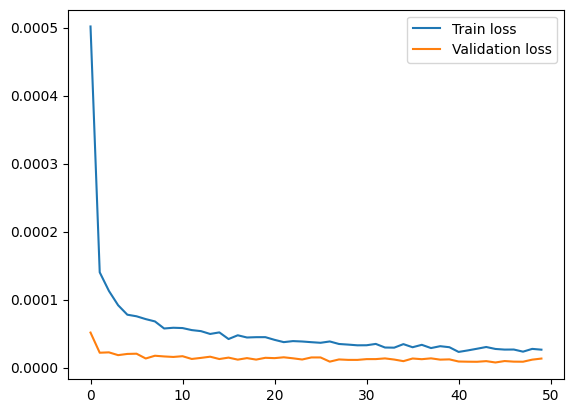

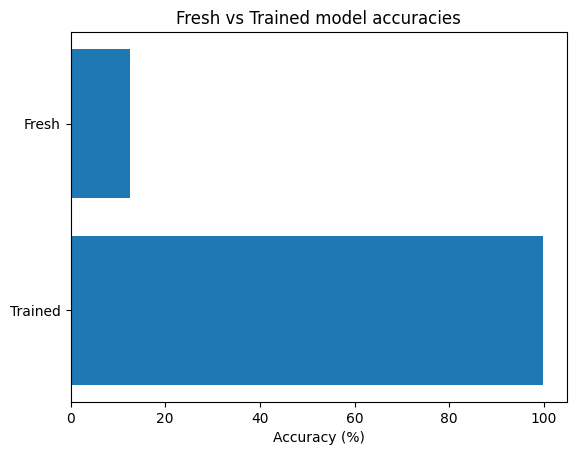

accuracy_trained,▁
train_loss,█▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▂
accuracy_trained,99.825
train_loss,3e-05
valid_loss,1e-05


In [3]:
config_name = "classifier_small.yaml"
config = cfg.load_config(config_name)
print("Config loaded:\n", config)

default_dirs = cfg.get_default_dirs()
models_dir = Path(default_dirs["models_dir"])
datasets_dir = Path(default_dirs["datasets_dir"])

name = ''.join(random.choices(string.ascii_lowercase, k=7))
name = config["name"]
# Hyperparameters
hyperparameters = config["hyperparameters"]
epochs = hyperparameters["epochs"]
learning_rate = hyperparameters["learning_rate"]
seed = hyperparameters["seed"]

# Model config
model_config = config["model"]
input_dim = model_config["input_dim"]
hidden_dims = model_config["hidden_dims"]
output_dim = model_config["output_dim"]
dropout = model_config.get("dropout", 0.0)
use_batch_norm = model_config.get("use_batch_norm", False)
output_activation = model_config.get("output_activation", "softmax")

# Load dataset
dataset_config = config["dataset"]
dataset_name = dataset_config["name"]
dataset_splits = dataset_config["splits"]
batch_size = dataset_config["batch_size"]
dataset_seed = dataset_config["seed"]

dataset_path = datasets_dir / dataset_name
print(dataset_path)
# Create a dataset
dataset = ModelParamsDataset(dataset_path, 45)

torch.manual_seed(dataset_seed)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Split into train, validation and test sets
dataset_train, dataset_valid, dataset_test = torch.utils.data.random_split(dataset, dataset_splits)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataloader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=True)
dataloader_test = torch.utils.data.DataLoader(dataset_test)

print("Train sample:", len(dataset_train))
print("Validation sample:", len(dataset_valid))
print("Test sample:", len(dataset_test))


torch.manual_seed(seed)
wandb_config = dotenv_values("../.env")
run = wandb.init(project=wandb_config["WANDB_PROJECT"], entity=wandb_config["WANDB_ENTITY"], config=config, group="weight_classifier")

# Init
model = MLP(input_dim, hidden_dims, output_dim, dropout, use_batch_norm, output_activation)
model.to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_losses, valid_losses = trainer.train_mlp(model, epochs, learning_rate, criterion, optimizer, dataloader_train, dataloader_valid)

plt.plot(train_losses, label="Train loss")
plt.plot(valid_losses, label="Validation loss")
plt.legend()
plt.show()

# Check improvement compared to a fresh model
model_fresh = MLP(input_dim, hidden_dims, output_dim, dropout, use_batch_norm, output_activation)
accuracy_fresh = trainer.get_accuracy(model_fresh, dataloader_test)
accuracy_trained = trainer.get_accuracy(model, dataloader_test)

wandb.log({"accuracy_trained": accuracy_trained})

plt.title("Fresh vs Trained model accuracies")
plt.barh(["Trained", "Fresh"], [accuracy_trained, accuracy_fresh])
plt.xlabel("Accuracy (%)")
plt.show()

model_path = models_dir / f"{name}.pth"
torch.save(model.state_dict(), model_path)

# Upload config and model to wandb
model_artifact = wandb.Artifact(f"classifier", type="model")
model_artifact.add_file(model_path)
run.log_artifact(model_artifact)

config_artifact = wandb.Artifact(f"classifier_config", type="config")
config_path = cfg.get_config_path(config_name)
config_artifact.add_file(config_path)
run.log_artifact(config_artifact)

wandb.alert(title="Model training finished", text=f"Model [{config_name}] training finished successfully.\n Accuracy: {accuracy_trained}")
wandb.finish()

## Latent space classifier

Config loaded:
 {'name': 'classifier_small', 'dataset': {'name': 'eight_angles_small_latent.csv', 'splits': [0.7, 0.2, 0.1], 'batch_size': 128, 'seed': 42}, 'hyperparameters': {'epochs': 50, 'learning_rate': 0.0001, 'optimizer': 'adam', 'criterion': 'bce', 'seed': 42}, 'model': {'input_dim': 10, 'hidden_dims': [200, 100], 'output_dim': 8, 'use_batch_norm': True, 'dropout': 0.4, 'output_activation': 'softmax'}}
C:\Projects\Python\master-thesis\data\eight_angles_small_latent.csv
Train sample: 56000
Validation sample: 16000
Test sample: 8000


100%|██████████| 50/50 [10:38<00:00, 12.77s/it]


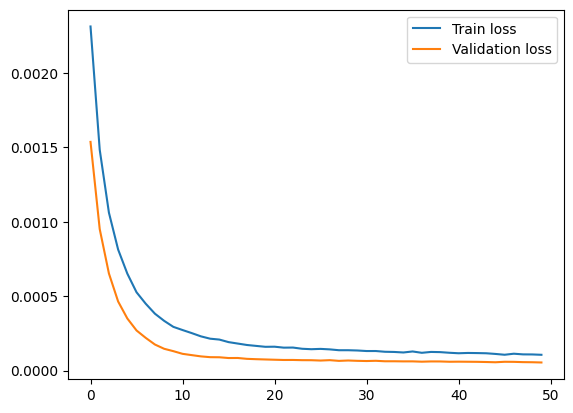

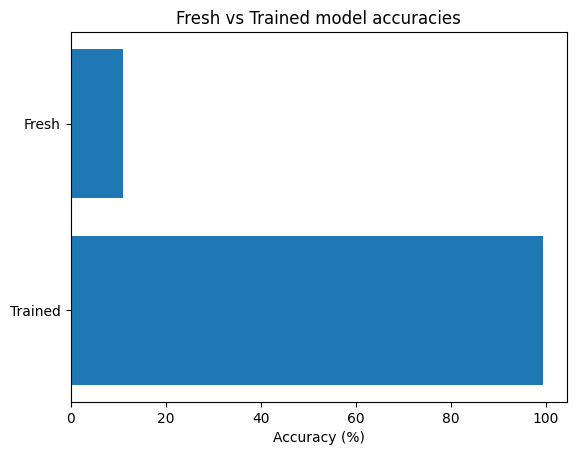

accuracy_trained,▁
train_loss,█▅▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▅▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy_trained,99.375
train_loss,0.00011
valid_loss,5e-05


In [4]:
config_name = "classifier_latent.yaml"
config = cfg.load_config(config_name)
print("Config loaded:\n", config)

default_dirs = cfg.get_default_dirs()
models_dir = Path(default_dirs["models_dir"])
datasets_dir = Path(default_dirs["datasets_dir"])

name = ''.join(random.choices(string.ascii_lowercase, k=7))
name = config["name"]
# Hyperparameters
hyperparameters = config["hyperparameters"]
epochs = hyperparameters["epochs"]
learning_rate = hyperparameters["learning_rate"]
seed = hyperparameters["seed"]

# Model config
model_config = config["model"]
input_dim = model_config["input_dim"]
hidden_dims = model_config["hidden_dims"]
output_dim = model_config["output_dim"]
dropout = model_config.get("dropout", 0.0)
use_batch_norm = model_config.get("use_batch_norm", False)
output_activation = model_config.get("output_activation", "softmax")

# Load dataset
dataset_config = config["dataset"]
dataset_name = dataset_config["name"]
dataset_splits = dataset_config["splits"]
batch_size = dataset_config["batch_size"]
dataset_seed = dataset_config["seed"]

dataset_path = datasets_dir / dataset_name
print(dataset_path)
# Create a dataset
dataset = ModelParamsDataset(dataset_path, 45)

torch.manual_seed(dataset_seed)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Split into train, validation and test sets
dataset_train, dataset_valid, dataset_test = torch.utils.data.random_split(dataset, dataset_splits)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataloader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=True)
dataloader_test = torch.utils.data.DataLoader(dataset_test)

print("Train sample:", len(dataset_train))
print("Validation sample:", len(dataset_valid))
print("Test sample:", len(dataset_test))


torch.manual_seed(seed)
wandb_config = dotenv_values("../.env")
run = wandb.init(project=wandb_config["WANDB_PROJECT"], entity=wandb_config["WANDB_ENTITY"], config=config, group="weight_classifier_latent")

# Init
model = MLP(input_dim, hidden_dims, output_dim, dropout, use_batch_norm, output_activation)
model.to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_losses, valid_losses = trainer.train_mlp(model, epochs, learning_rate, criterion, optimizer, dataloader_train, dataloader_valid)

plt.plot(train_losses, label="Train loss")
plt.plot(valid_losses, label="Validation loss")
plt.legend()
plt.show()

# Check improvement compared to a fresh model
model_fresh = MLP(input_dim, hidden_dims, output_dim, dropout, use_batch_norm, output_activation)
accuracy_fresh = trainer.get_accuracy(model_fresh, dataloader_test)
accuracy_trained = trainer.get_accuracy(model, dataloader_test)

wandb.log({"accuracy_trained": accuracy_trained})

plt.title("Fresh vs Trained model accuracies")
plt.barh(["Trained", "Fresh"], [accuracy_trained, accuracy_fresh])
plt.xlabel("Accuracy (%)")
plt.show()

model_path = models_dir / f"{name}.pth"
torch.save(model.state_dict(), model_path)

# Upload config and model to wandb
model_artifact = wandb.Artifact(f"classifier", type="model")
model_artifact.add_file(model_path)
run.log_artifact(model_artifact)

config_artifact = wandb.Artifact(f"classifier_config", type="config")
config_path = cfg.get_config_path(config_name)
config_artifact.add_file(config_path)
run.log_artifact(config_artifact)

wandb.alert(title="Model training finished", text=f"Model [{config_name}] training finished successfully.\n Accuracy: {accuracy_trained}")
wandb.finish()